In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
prevSampled=0
nSamples=36
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [6]:
name_train='conditionClf_lord_p2p_sharedRecon_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)
if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    if epoch%10==0:
        print(' Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all


In [8]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

### load lord

In [9]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001


name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('/data/xinyi/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('/data/xinyi/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

loadEpoch='3399'
loadEpoch_decoder=372

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]

dna_cShared=hidden5-dfilterSize
p_cShared=dna_cShared

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
    modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
modelcnn_dna_dec.cuda().eval()
modelcnn_protein_dec.cuda().eval()
modelcnn_dnaShared_dec.cuda().eval()
modelcnn_pShared_dec.cuda().eval()

batchsize=328
pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()


with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
    pIDemb_dec.weight=pickle.load(output)

with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dnaShared_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_proteinShared_dec=pickle.load(output)

modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
pIDemb_dec.weight.requires_grad=False

with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
    modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
modelcnn_dna.cuda()
modelcnn_protein.cuda()
modelcnn_dna.load_state_dict(stateDict_train_dna[loadEpoch_decoder])
modelcnn_protein.load_state_dict(stateDict_train_protein[loadEpoch_decoder])



<All keys matched successfully>

In [10]:
modelcnn_dna.eval()
modelcnn_protein.eval()

CNN_VAE_split_encode_pIDemb(
  (pIDemb): Embedding(6, 64)
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

### train classifier

In [11]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
18
cd16
4555


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1566 loss_val: 1.1765 time: 6.3137s
 Epoch: 0010 loss_train: 0.4072 loss_val: 1.7645 time: 8.3150s
 Epoch: 0020 loss_train: 0.1593 loss_val: 2.2505 time: 5.3947s
 Epoch: 0030 loss_train: 0.0185 loss_val: 2.4291 time: 6.1567s
 Epoch: 0040 loss_train: 0.0213 loss_val: 2.7224 time: 7.1733s
 Epoch: 0050 loss_train: 0.0131 loss_val: 2.6230 time: 5.5765s
 Epoch: 0060 loss_train: 0.0041 loss_val: 2.6009 time: 6.5900s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.6167 time: 5.4165s
 Epoch: 0080 loss_train: 0.0003 loss_val: 2.6677 time: 4.3582s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.7051 time: 7.7307s
 Epoch: 0100 loss_train: 0.0002 loss_val: 2.7349 time: 7.8129s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.7608 time: 7.3144s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7842 time: 7.2076s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.8059 time: 6.6088s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.8267 time: 6.2120s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.8464 time: 

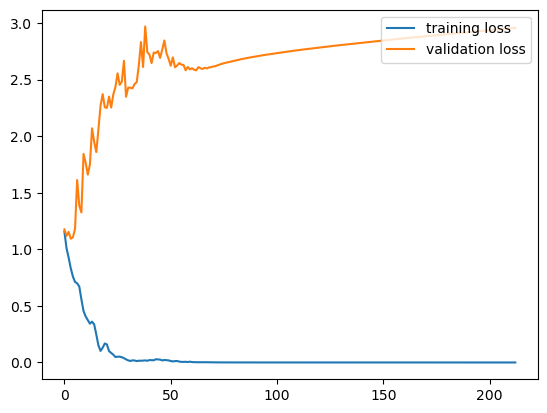

cd3
3760


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0259 loss_val: 1.1048 time: 7.2358s
 Epoch: 0010 loss_train: 0.0199 loss_val: 1.1446 time: 6.5465s
 Epoch: 0020 loss_train: 0.0171 loss_val: 1.6130 time: 6.7070s
 Epoch: 0030 loss_train: 0.0258 loss_val: 2.2565 time: 7.6438s
 Epoch: 0050 loss_train: 0.0186 loss_val: 1.7309 time: 5.8426s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.6143 time: 5.9538s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.6202 time: 4.8132s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6269 time: 6.5061s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6337 time: 6.2115s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6403 time: 6.0438s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6467 time: 5.5983s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6531 time: 7.1914s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6595 time: 6.0854s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6660 time: 6.1401s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6726 time: 6.8060s
 Epoch: 0160 loss_train: 0.0000 loss_val: 1.6790 time: 

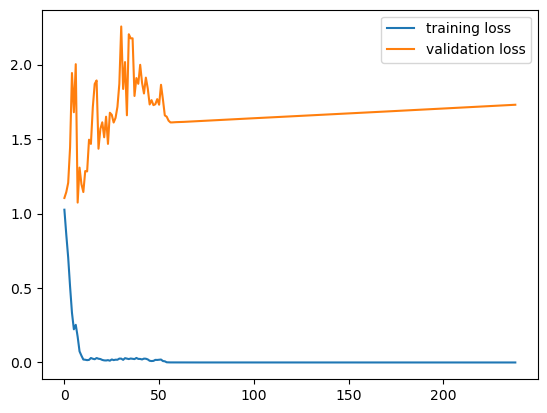

cd4
5580


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2029 loss_val: 1.4602 time: 9.5179s
 Epoch: 0010 loss_train: 0.3165 loss_val: 1.5775 time: 8.4377s
 Epoch: 0020 loss_train: 0.0827 loss_val: 2.2040 time: 9.0323s
 Epoch: 0030 loss_train: 0.0126 loss_val: 2.2697 time: 8.4779s
 Epoch: 0040 loss_train: 0.0022 loss_val: 2.3187 time: 7.9156s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.3420 time: 9.1377s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.3782 time: 9.0318s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.4042 time: 6.9949s
 Epoch: 0080 loss_train: 0.0025 loss_val: 2.4534 time: 8.8405s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.4675 time: 8.6375s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.4926 time: 8.2820s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.5002 time: 8.1481s
 Epoch: 0120 loss_train: 0.5562 loss_val: 1.5980 time: 7.9860s
 Epoch: 0130 loss_train: 0.0196 loss_val: 2.4034 time: 9.6187s
 Epoch: 0140 loss_train: 0.0041 loss_val: 2.6430 time: 11.1590s
 Epoch: 0150 loss_train: 0.0014 loss_val: 2.6189 time:

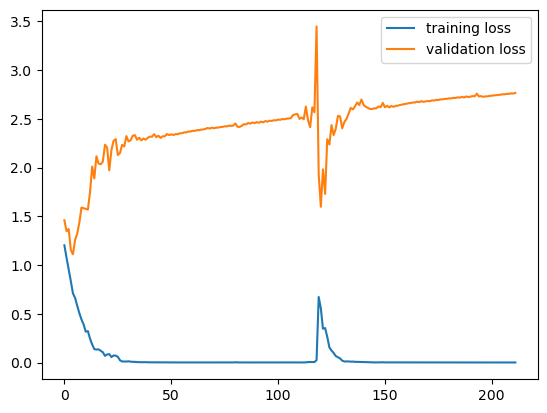

cd8
5604


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2154 loss_val: 1.6926 time: 8.6628s
 Epoch: 0010 loss_train: 0.2227 loss_val: 2.4831 time: 8.5720s
 Epoch: 0020 loss_train: 0.0082 loss_val: 2.0745 time: 8.4627s
 Epoch: 0030 loss_train: 0.0010 loss_val: 2.0191 time: 7.2326s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.0752 time: 7.6115s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1207 time: 9.9309s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1601 time: 9.0537s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1952 time: 9.5739s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2269 time: 9.6430s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2562 time: 8.3622s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2836 time: 9.8623s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3097 time: 9.7055s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3343 time: 7.3680s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3582 time: 7.9314s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3812 time: 7.6102s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4034 time: 

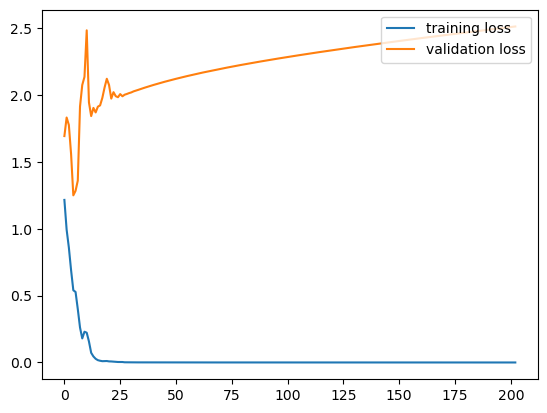

gh2ax
4837


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0109 loss_val: 1.9111 time: 6.9999s
 Epoch: 0010 loss_train: 0.0149 loss_val: 1.1268 time: 7.1172s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.0507 time: 6.7372s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.0860 time: 7.5326s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1138 time: 7.8381s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1369 time: 4.9760s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1572 time: 6.7818s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.1752 time: 7.7888s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1915 time: 7.7741s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2069 time: 9.1388s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2210 time: 8.5078s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2344 time: 6.3669s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2472 time: 7.8002s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.2593 time: 5.9532s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.2710 time: 7.3415s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.2823 time: 

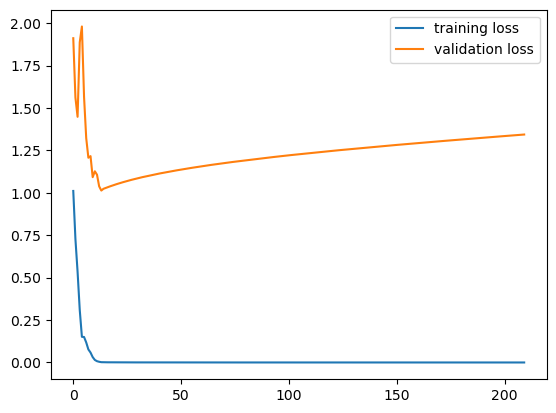

lamin
4838


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1254 loss_val: 1.6039 time: 7.3084s
 Epoch: 0010 loss_train: 0.1126 loss_val: 1.1981 time: 6.7596s
 Epoch: 0020 loss_train: 0.0071 loss_val: 1.1340 time: 6.5001s
 Epoch: 0030 loss_train: 0.0040 loss_val: 1.2383 time: 5.5052s
 Epoch: 0040 loss_train: 0.0035 loss_val: 1.2756 time: 5.8516s
 Epoch: 0050 loss_train: 0.0520 loss_val: 1.6722 time: 8.3630s
 Epoch: 0060 loss_train: 0.0008 loss_val: 1.2533 time: 7.8658s
 Epoch: 0070 loss_train: 0.0004 loss_val: 1.2935 time: 7.5184s
 Epoch: 0080 loss_train: 0.0003 loss_val: 1.3178 time: 6.5489s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.3367 time: 7.7508s
 Epoch: 0100 loss_train: 0.0002 loss_val: 1.3525 time: 7.5999s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3666 time: 7.5938s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3792 time: 8.6186s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3911 time: 8.2023s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4021 time: 8.4382s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4128 time: 

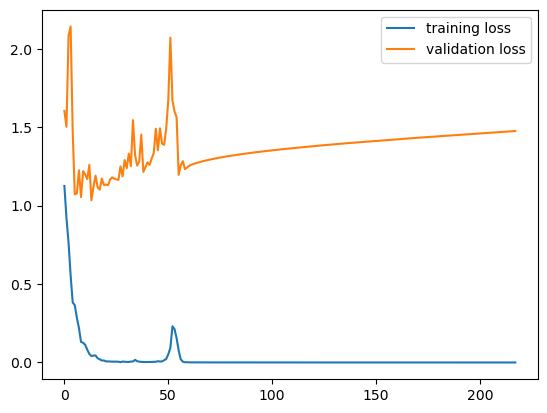

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
cd16
4490


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1464 loss_val: 1.2186 time: 6.7610s
 Epoch: 0010 loss_train: 0.4399 loss_val: 1.7238 time: 6.5798s
 Epoch: 0020 loss_train: 0.0661 loss_val: 2.1935 time: 6.3672s
 Epoch: 0030 loss_train: 0.0389 loss_val: 2.4704 time: 8.6542s
 Epoch: 0040 loss_train: 0.0224 loss_val: 2.8667 time: 7.7297s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.6049 time: 8.3431s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.6103 time: 7.6653s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.6261 time: 7.7032s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6418 time: 6.0292s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.6572 time: 6.0363s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6720 time: 7.3607s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6860 time: 6.6133s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7001 time: 8.4551s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7137 time: 8.5076s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.7270 time: 8.0005s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.7403 time: 

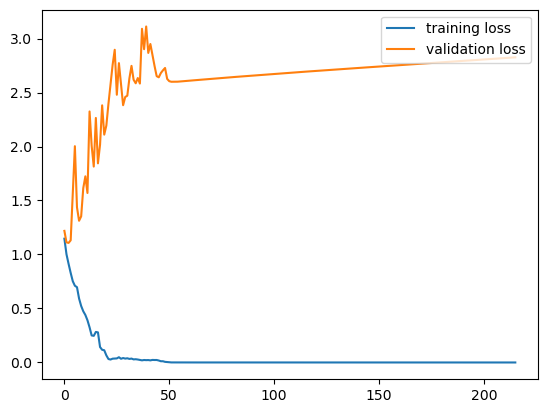

cd3
3802


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0093 loss_val: 1.0975 time: 5.3786s
 Epoch: 0010 loss_train: 0.2055 loss_val: 1.0091 time: 6.2299s
 Epoch: 0020 loss_train: 0.0018 loss_val: 1.1379 time: 6.6220s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.1775 time: 4.5337s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.2117 time: 5.8440s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.2390 time: 4.9018s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2621 time: 3.8762s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2821 time: 5.8364s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3003 time: 5.6576s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.3167 time: 5.3437s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3318 time: 5.7871s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3459 time: 5.5843s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3592 time: 6.3083s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3718 time: 6.7671s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3839 time: 5.7525s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3953 time: 

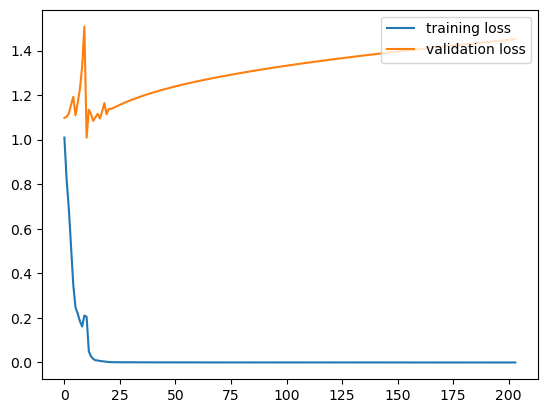

cd4
5518


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1792 loss_val: 1.5027 time: 10.4517s
 Epoch: 0010 loss_train: 0.3499 loss_val: 1.5507 time: 7.5986s
 Epoch: 0020 loss_train: 0.0818 loss_val: 2.0847 time: 9.4832s
 Epoch: 0030 loss_train: 0.0025 loss_val: 2.2885 time: 8.8618s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.3204 time: 9.2264s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.3599 time: 8.4085s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.3946 time: 6.4254s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4257 time: 6.5618s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4545 time: 6.9041s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4815 time: 7.5618s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.5068 time: 5.8543s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.5312 time: 7.3656s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5546 time: 10.1404s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5769 time: 9.2841s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5988 time: 8.9731s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.6202 time

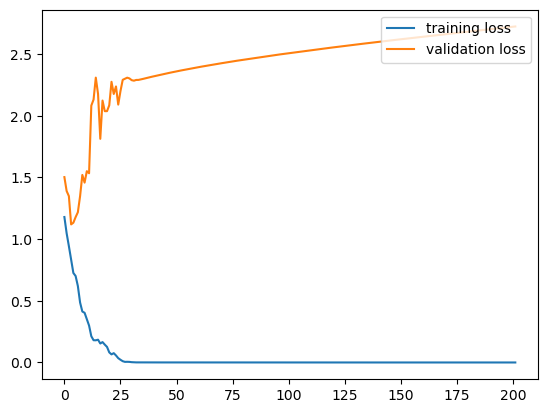

cd8
5545


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1883 loss_val: 1.6911 time: 9.6141s
 Epoch: 0010 loss_train: 0.0655 loss_val: 1.8514 time: 9.4934s
 Epoch: 0020 loss_train: 0.0090 loss_val: 2.0402 time: 9.2085s
 Epoch: 0030 loss_train: 0.0007 loss_val: 2.0751 time: 9.4824s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.1137 time: 6.9202s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.1486 time: 9.3412s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.1795 time: 6.8856s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2078 time: 8.9488s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2339 time: 8.3551s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2584 time: 6.2730s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2815 time: 6.0044s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3037 time: 10.2602s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3250 time: 9.0098s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3454 time: 8.6909s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3654 time: 9.2237s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3851 time:

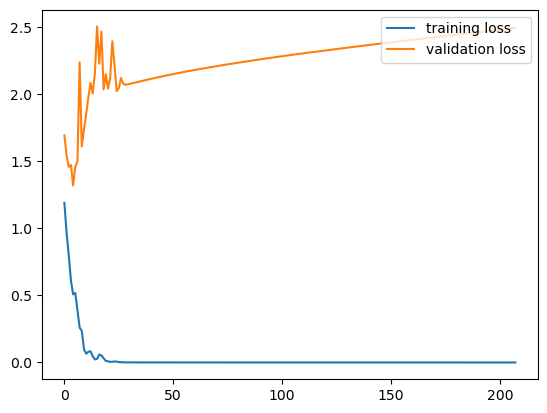

gh2ax
4931


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9918 loss_val: 2.1554 time: 5.8401s
 Epoch: 0010 loss_train: 0.0085 loss_val: 1.0931 time: 8.0811s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.1012 time: 6.5058s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.1383 time: 7.6263s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1680 time: 6.8905s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1928 time: 6.2644s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2146 time: 6.9668s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2340 time: 6.7453s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2518 time: 8.0355s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2684 time: 6.6375s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2838 time: 6.3751s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2984 time: 7.6461s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3123 time: 6.7427s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3258 time: 7.2108s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3387 time: 6.3795s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3512 time: 

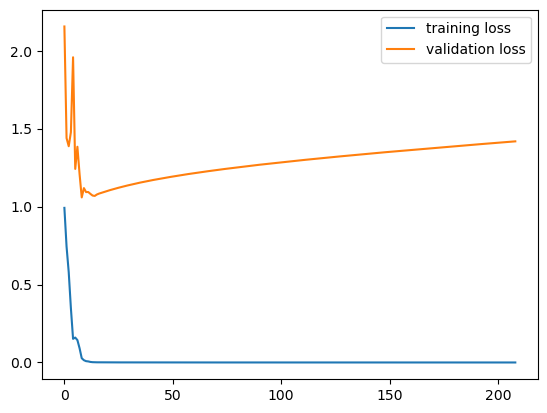

lamin
4932


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1837 loss_val: 1.5142 time: 5.8303s
 Epoch: 0010 loss_train: 0.0949 loss_val: 1.9757 time: 7.1966s
 Epoch: 0020 loss_train: 0.0219 loss_val: 1.3389 time: 6.0661s
 Epoch: 0030 loss_train: 0.0071 loss_val: 1.4342 time: 7.0033s
 Epoch: 0040 loss_train: 0.0071 loss_val: 1.5165 time: 7.8359s
 Epoch: 0050 loss_train: 0.0018 loss_val: 1.6895 time: 7.5083s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5045 time: 7.7989s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5181 time: 6.9811s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5302 time: 5.7711s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5413 time: 6.9373s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5518 time: 7.2759s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5622 time: 7.6546s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5722 time: 6.5431s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5820 time: 7.1089s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5917 time: 6.9149s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6013 time: 

/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1490 loss_val: 1.1947 time: 5.7433s
 Epoch: 0010 loss_train: 0.4372 loss_val: 2.2391 time: 7.1452s
 Epoch: 0020 loss_train: 0.1707 loss_val: 2.4001 time: 7.8351s
 Epoch: 0030 loss_train: 0.0430 loss_val: 2.7998 time: 6.2878s
 Epoch: 0040 loss_train: 0.0318 loss_val: 2.7879 time: 6.0011s
 Epoch: 0050 loss_train: 0.0060 loss_val: 2.5636 time: 6.3934s
 Epoch: 0060 loss_train: 0.0038 loss_val: 2.6138 time: 5.9287s
 Epoch: 0070 loss_train: 0.0021 loss_val: 2.6443 time: 7.0838s
 Epoch: 0080 loss_train: 0.0009 loss_val: 2.6772 time: 6.0358s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.7083 time: 6.4981s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.7491 time: 5.7332s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.7779 time: 8.0472s
 Epoch: 0120 loss_train: 0.0216 loss_val: 2.7723 time: 7.3643s
 Epoch: 0130 loss_train: 0.0373 loss_val: 2.8027 time: 7.3073s
 Epoch: 0140 loss_train: 0.0051 loss_val: 2.7955 time: 7.3655s
 Epoch: 0150 loss_train: 0.0024 loss_val: 2.8633 time: 

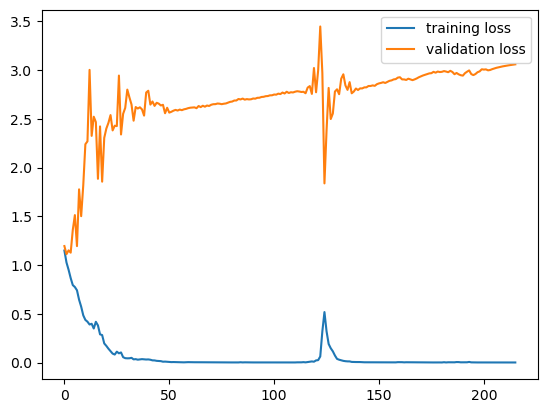

cd3
3806


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0297 loss_val: 1.0976 time: 4.8121s
 Epoch: 0010 loss_train: 0.0482 loss_val: 1.2520 time: 5.2881s
 Epoch: 0020 loss_train: 0.0101 loss_val: 1.6279 time: 6.0021s
 Epoch: 0030 loss_train: 0.0375 loss_val: 1.9483 time: 4.8301s
 Epoch: 0040 loss_train: 0.0398 loss_val: 2.2264 time: 6.0050s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.4972 time: 6.0145s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5106 time: 5.9591s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5234 time: 4.1621s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5352 time: 6.1175s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5459 time: 5.1850s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5560 time: 6.3465s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5656 time: 5.5822s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5749 time: 6.2688s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5838 time: 6.1363s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5925 time: 5.5268s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6010 time: 

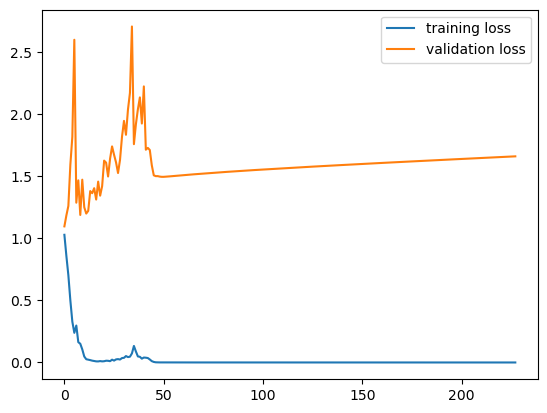

cd4
5663


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2214 loss_val: 1.5537 time: 8.2859s
 Epoch: 0010 loss_train: 0.4171 loss_val: 1.6409 time: 8.6519s
 Epoch: 0020 loss_train: 0.1583 loss_val: 1.9260 time: 8.5594s
 Epoch: 0030 loss_train: 0.0381 loss_val: 2.8452 time: 8.5050s
 Epoch: 0040 loss_train: 0.0055 loss_val: 2.3426 time: 8.5841s
 Epoch: 0050 loss_train: 0.0007 loss_val: 2.4205 time: 8.2364s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.4579 time: 8.7332s
 Epoch: 0070 loss_train: 0.0004 loss_val: 2.4898 time: 8.1255s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.5169 time: 8.3805s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.5424 time: 8.2181s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.5651 time: 9.3546s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.5877 time: 7.5958s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.6075 time: 9.0759s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.6304 time: 7.7081s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.6484 time: 7.1328s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.6692 time: 

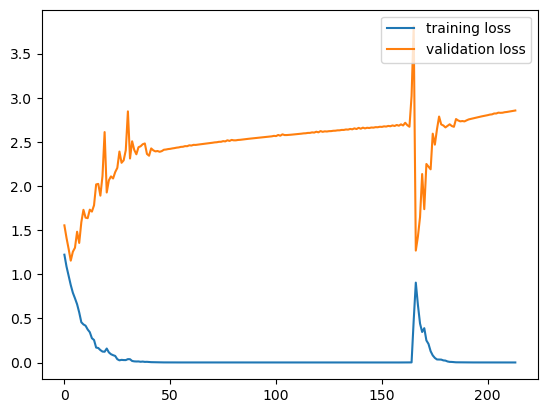

cd8
5687


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2233 loss_val: 1.6646 time: 8.2648s
 Epoch: 0010 loss_train: 0.1378 loss_val: 1.9058 time: 8.0292s
 Epoch: 0020 loss_train: 0.0152 loss_val: 2.0799 time: 8.7600s
 Epoch: 0030 loss_train: 0.0014 loss_val: 2.1176 time: 5.9530s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.1785 time: 8.4507s
 Epoch: 0050 loss_train: 0.0005 loss_val: 2.2224 time: 7.5765s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2643 time: 8.4759s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3008 time: 7.9098s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.3336 time: 8.5902s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.3636 time: 8.5257s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3917 time: 8.3193s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4182 time: 8.6022s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4435 time: 8.6564s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4678 time: 6.2978s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4911 time: 6.8867s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5141 time: 

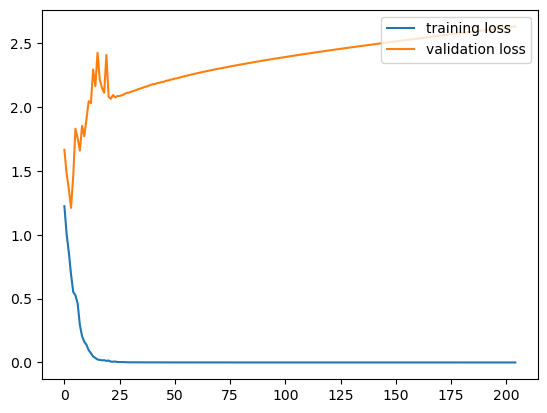

gh2ax
4889


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0543 loss_val: 1.5863 time: 6.8487s
 Epoch: 0010 loss_train: 0.0045 loss_val: 1.1492 time: 8.0998s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1725 time: 6.9993s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2130 time: 8.6263s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2441 time: 6.1840s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2702 time: 7.4595s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2927 time: 6.8332s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3127 time: 7.6176s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3310 time: 6.8032s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3477 time: 6.9878s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3637 time: 5.9654s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3785 time: 6.8355s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3928 time: 5.3835s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4065 time: 8.1742s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4200 time: 5.4820s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4328 time: 

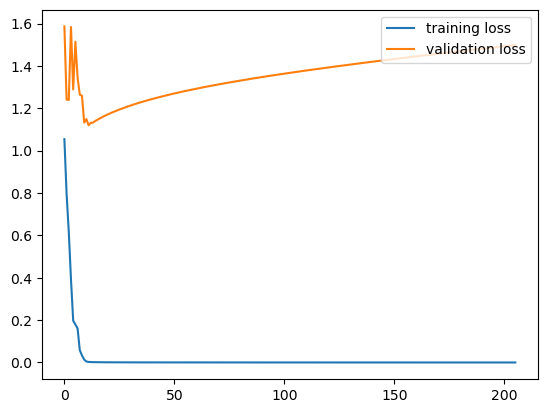

lamin
4890


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2144 loss_val: 1.4125 time: 6.8135s
 Epoch: 0010 loss_train: 0.1517 loss_val: 1.3341 time: 7.2159s
 Epoch: 0020 loss_train: 0.0051 loss_val: 1.3462 time: 6.5124s
 Epoch: 0030 loss_train: 0.0055 loss_val: 1.4228 time: 4.8608s
 Epoch: 0040 loss_train: 0.0320 loss_val: 1.5664 time: 4.8772s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.4722 time: 7.2215s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4945 time: 6.3271s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5116 time: 5.3979s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5263 time: 6.9617s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5395 time: 6.5959s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5519 time: 5.4089s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5636 time: 5.2391s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5748 time: 7.1875s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5857 time: 7.8846s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5963 time: 6.1127s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6066 time: 

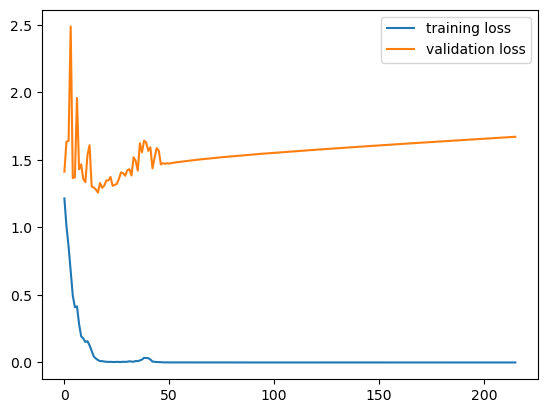

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
cd16
4560


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1594 loss_val: 1.2125 time: 6.0679s
 Epoch: 0010 loss_train: 0.4674 loss_val: 1.6087 time: 5.9833s
 Epoch: 0020 loss_train: 0.2488 loss_val: 2.1403 time: 5.3256s
 Epoch: 0030 loss_train: 0.0142 loss_val: 2.2587 time: 5.9763s
 Epoch: 0040 loss_train: 0.0222 loss_val: 2.3975 time: 6.8500s
 Epoch: 0050 loss_train: 0.0079 loss_val: 2.4174 time: 7.6615s
 Epoch: 0060 loss_train: 0.0012 loss_val: 2.4149 time: 6.4091s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.4543 time: 7.2023s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.4827 time: 6.1334s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.5104 time: 6.1000s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.5302 time: 6.0212s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.5551 time: 6.5022s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.5742 time: 7.9890s
 Epoch: 0130 loss_train: 0.0008 loss_val: 2.5900 time: 6.7955s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.6058 time: 6.8703s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.6281 time: 

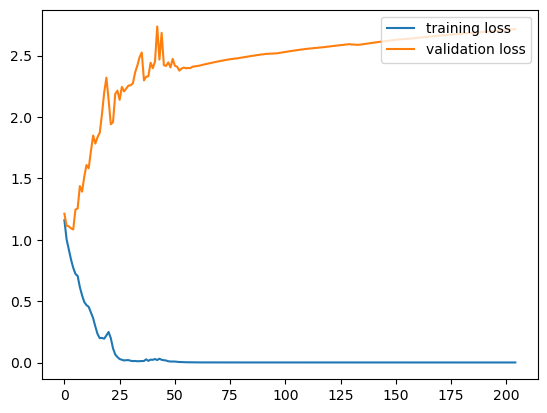

cd3
3772


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0132 loss_val: 1.0871 time: 4.8189s
 Epoch: 0010 loss_train: 0.0509 loss_val: 1.2630 time: 5.4342s
 Epoch: 0020 loss_train: 0.0342 loss_val: 1.7032 time: 5.6143s
 Epoch: 0030 loss_train: 0.0232 loss_val: 1.9378 time: 5.9491s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.5563 time: 5.0648s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5656 time: 6.3176s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5768 time: 6.1558s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5878 time: 7.1160s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5983 time: 5.7483s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6085 time: 6.4887s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6180 time: 5.5238s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6274 time: 7.0049s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6363 time: 5.8563s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6451 time: 7.2471s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6538 time: 5.1820s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6623 time: 

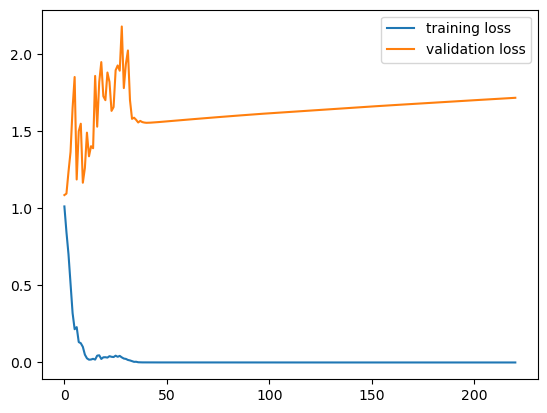

cd4
5602


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2070 loss_val: 1.5213 time: 7.1094s
 Epoch: 0010 loss_train: 0.2978 loss_val: 1.6567 time: 9.7976s
 Epoch: 0020 loss_train: 0.0960 loss_val: 2.0617 time: 7.7199s
 Epoch: 0030 loss_train: 0.0136 loss_val: 2.3269 time: 6.4654s
 Epoch: 0040 loss_train: 0.0027 loss_val: 2.2864 time: 7.3796s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.3086 time: 8.0282s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.3268 time: 9.7272s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.3579 time: 9.7351s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.3872 time: 8.8973s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.4144 time: 9.8122s
 Epoch: 0100 loss_train: 0.0008 loss_val: 2.4576 time: 6.6869s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.4559 time: 7.5624s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.4822 time: 8.2241s
 Epoch: 0130 loss_train: 0.0011 loss_val: 2.5136 time: 8.2693s
 Epoch: 0140 loss_train: 0.2225 loss_val: 2.1020 time: 9.3150s
 Epoch: 0150 loss_train: 0.0130 loss_val: 2.5206 time: 

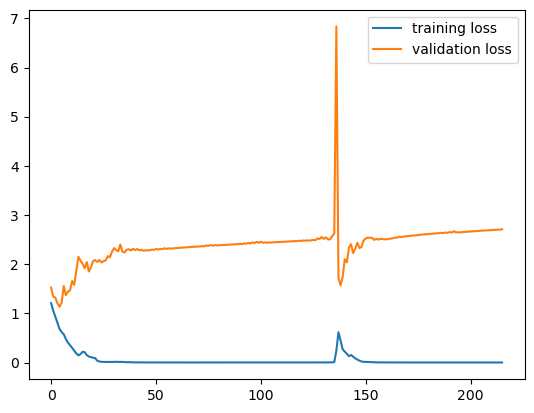

cd8
5625


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2104 loss_val: 1.8416 time: 10.3065s
 Epoch: 0010 loss_train: 0.1193 loss_val: 2.1855 time: 9.7595s
 Epoch: 0020 loss_train: 0.0107 loss_val: 1.8727 time: 8.6716s
 Epoch: 0030 loss_train: 0.0030 loss_val: 1.9275 time: 8.7145s
 Epoch: 0040 loss_train: 0.0014 loss_val: 1.9771 time: 9.3808s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.0229 time: 7.2934s
 Epoch: 0060 loss_train: 0.0011 loss_val: 2.0602 time: 8.9348s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.0932 time: 7.7758s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.1217 time: 9.2421s
 Epoch: 0090 loss_train: 0.0010 loss_val: 2.1741 time: 8.2614s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.1765 time: 7.5780s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.2165 time: 8.7041s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.2526 time: 10.0058s
 Epoch: 0130 loss_train: 0.0007 loss_val: 2.2695 time: 9.3600s
 Epoch: 0140 loss_train: 0.0007 loss_val: 2.2973 time: 9.5453s
 Epoch: 0150 loss_train: 0.9050 loss_val: 1.8464 time

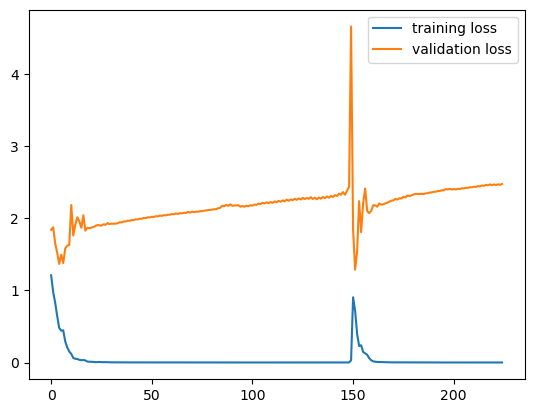

gh2ax
4892


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0445 loss_val: 1.5696 time: 9.0547s
 Epoch: 0010 loss_train: 0.0256 loss_val: 1.1537 time: 7.2993s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2226 time: 7.2607s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2607 time: 8.1426s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2908 time: 7.5754s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3158 time: 7.0481s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3376 time: 7.2496s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3571 time: 7.9953s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3750 time: 6.9450s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3916 time: 6.2547s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4072 time: 7.4788s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4220 time: 6.5226s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4361 time: 5.0835s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4497 time: 5.5591s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4629 time: 8.0855s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4757 time: 

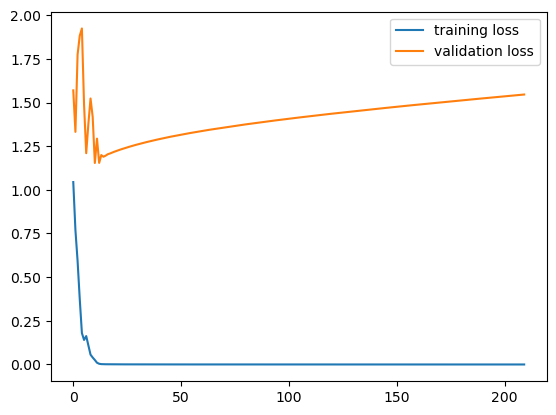

lamin
4893


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1948 loss_val: 1.4179 time: 8.3441s
 Epoch: 0010 loss_train: 0.1694 loss_val: 1.2162 time: 6.9894s
 Epoch: 0020 loss_train: 0.0227 loss_val: 1.3708 time: 7.3676s
 Epoch: 0030 loss_train: 0.0211 loss_val: 1.8596 time: 7.4702s
 Epoch: 0040 loss_train: 0.0043 loss_val: 1.4707 time: 8.4733s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4426 time: 7.1471s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4558 time: 7.5823s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4685 time: 6.1093s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4802 time: 7.7699s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4914 time: 7.0944s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5020 time: 6.7705s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5121 time: 7.5019s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5218 time: 7.7377s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5314 time: 7.6184s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5407 time: 7.0074s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5499 time: 

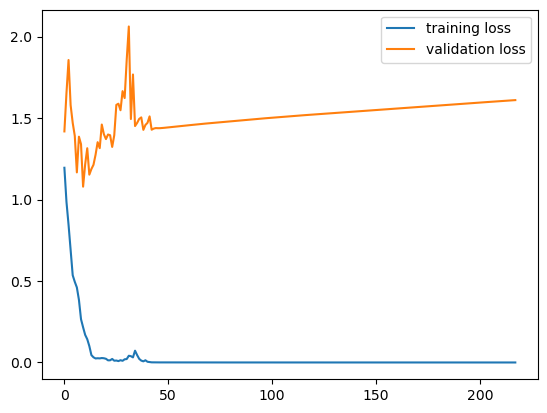

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
22
cd16
4544


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1264 loss_val: 1.1983 time: 8.3447s
 Epoch: 0010 loss_train: 0.4635 loss_val: 1.7790 time: 6.8643s
 Epoch: 0020 loss_train: 0.1735 loss_val: 3.2739 time: 5.2486s
 Epoch: 0030 loss_train: 0.0641 loss_val: 2.5078 time: 6.5567s
 Epoch: 0040 loss_train: 0.0545 loss_val: 2.5633 time: 5.7778s
 Epoch: 0050 loss_train: 0.0211 loss_val: 2.5710 time: 7.7298s
 Epoch: 0060 loss_train: 0.0024 loss_val: 2.6356 time: 6.4023s
 Epoch: 0070 loss_train: 0.0015 loss_val: 2.6770 time: 6.4192s
 Epoch: 0080 loss_train: 0.0011 loss_val: 2.7002 time: 6.6310s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.7335 time: 6.4585s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.7558 time: 6.5139s
 Epoch: 0110 loss_train: 0.0011 loss_val: 2.7615 time: 6.9448s
 Epoch: 0120 loss_train: 0.0009 loss_val: 2.7867 time: 7.0509s
 Epoch: 0130 loss_train: 0.0009 loss_val: 2.8089 time: 6.9644s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.8319 time: 8.5780s
 Epoch: 0150 loss_train: 0.0009 loss_val: 2.8380 time: 

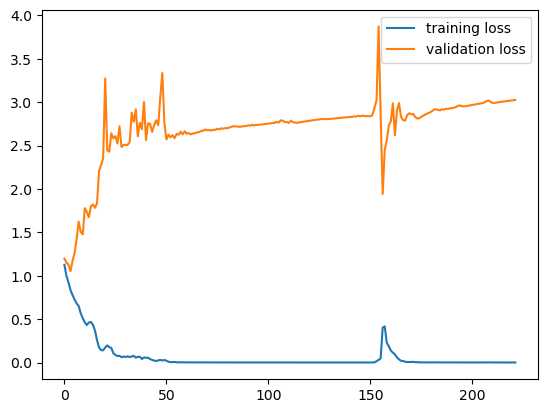

cd3
3781


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0339 loss_val: 1.0860 time: 5.4442s
 Epoch: 0010 loss_train: 0.0207 loss_val: 1.2393 time: 4.8500s
 Epoch: 0020 loss_train: 0.0040 loss_val: 1.2944 time: 5.5605s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.3278 time: 6.4860s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3583 time: 6.6208s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3838 time: 6.3625s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4059 time: 6.4299s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4257 time: 6.0693s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4435 time: 5.1177s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4599 time: 4.4704s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4752 time: 6.3765s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4895 time: 5.5804s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5032 time: 6.6674s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5161 time: 5.3962s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5285 time: 4.6954s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5404 time: 

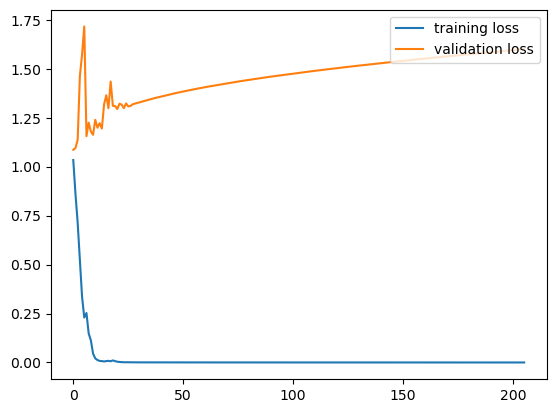

cd4
5579


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2198 loss_val: 1.6170 time: 9.5672s
 Epoch: 0010 loss_train: 0.2798 loss_val: 1.6550 time: 7.3558s
 Epoch: 0020 loss_train: 0.1137 loss_val: 1.9501 time: 6.4314s
 Epoch: 0030 loss_train: 0.0121 loss_val: 2.3171 time: 9.0628s
 Epoch: 0040 loss_train: 0.0161 loss_val: 2.4007 time: 9.9013s
 Epoch: 0050 loss_train: 0.0234 loss_val: 2.9128 time: 7.1552s
 Epoch: 0060 loss_train: 0.0138 loss_val: 2.9132 time: 8.0830s
 Epoch: 0070 loss_train: 0.0051 loss_val: 2.5005 time: 9.0470s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.5003 time: 9.6457s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.5293 time: 7.7132s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.5378 time: 8.5828s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.5724 time: 8.0447s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.5693 time: 7.5571s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.6073 time: 6.4480s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.6022 time: 6.8491s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.6410 time: 

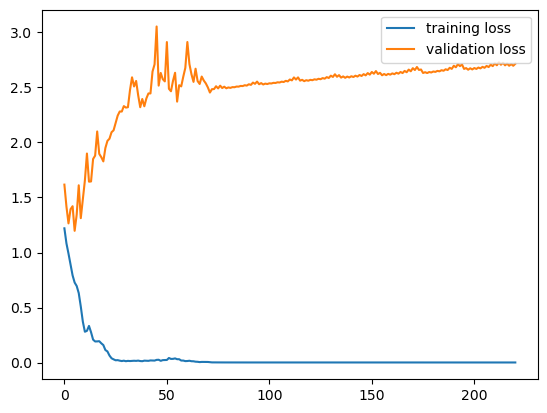

cd8
5605


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2158 loss_val: 1.7269 time: 8.4649s
 Epoch: 0010 loss_train: 0.2160 loss_val: 1.8360 time: 7.9133s
 Epoch: 0020 loss_train: 0.0048 loss_val: 1.9323 time: 6.8599s
 Epoch: 0030 loss_train: 0.0014 loss_val: 2.0316 time: 8.7326s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.0956 time: 8.3617s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.1425 time: 7.3612s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.1817 time: 6.9652s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.2070 time: 8.5723s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.2418 time: 9.4148s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.2757 time: 5.0220s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.3066 time: 6.3323s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3325 time: 7.1389s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.3582 time: 8.0705s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.4137 time: 7.9404s
 Epoch: 0140 loss_train: 0.1133 loss_val: 2.1606 time: 7.8356s
 Epoch: 0150 loss_train: 0.0014 loss_val: 2.3044 time: 

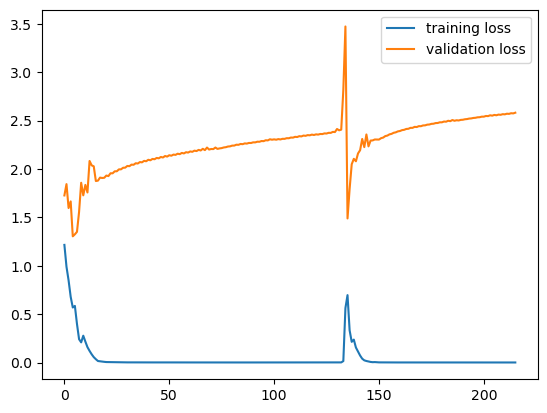

gh2ax
4926


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0342 loss_val: 1.6057 time: 6.6888s
 Epoch: 0010 loss_train: 0.0075 loss_val: 1.2803 time: 8.3674s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.2188 time: 6.1728s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2559 time: 8.7266s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2841 time: 7.1168s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3080 time: 8.0685s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3286 time: 6.8819s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3470 time: 8.3337s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3640 time: 7.2073s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3801 time: 6.6015s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3950 time: 6.7297s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4093 time: 7.7402s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4228 time: 6.7611s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.4359 time: 8.1980s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4486 time: 7.2294s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4608 time: 

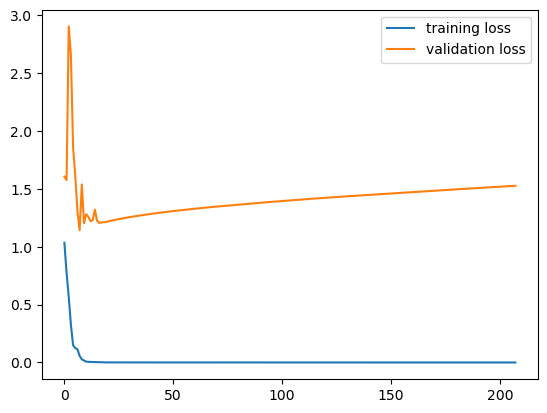

lamin
4927


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2023 loss_val: 1.5011 time: 7.0685s
 Epoch: 0010 loss_train: 0.1423 loss_val: 1.2662 time: 8.5853s
 Epoch: 0020 loss_train: 0.0131 loss_val: 1.3715 time: 7.6855s
 Epoch: 0030 loss_train: 0.0117 loss_val: 1.6152 time: 8.0555s
 Epoch: 0040 loss_train: 0.0115 loss_val: 1.7323 time: 7.7127s
 Epoch: 0050 loss_train: 0.0303 loss_val: 1.4504 time: 7.5548s
 Epoch: 0060 loss_train: 0.0005 loss_val: 1.4605 time: 6.7416s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.4865 time: 6.9642s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5078 time: 7.2448s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5263 time: 7.5507s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5426 time: 7.3978s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5572 time: 7.5066s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5707 time: 8.4131s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5836 time: 7.5376s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5958 time: 8.1545s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6074 time: 

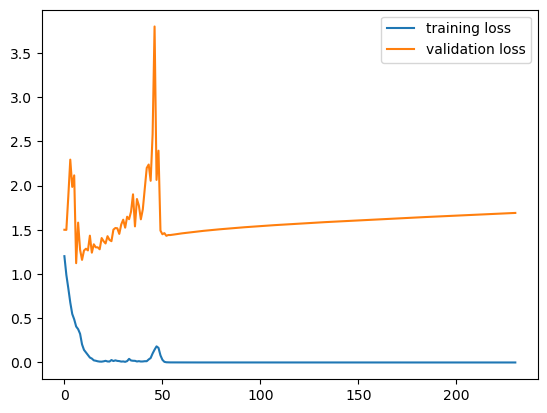

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
23
cd16
4608


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1723 loss_val: 1.1743 time: 7.3045s
 Epoch: 0010 loss_train: 0.5194 loss_val: 1.4554 time: 8.5878s
 Epoch: 0020 loss_train: 0.1223 loss_val: 2.2583 time: 6.9243s
 Epoch: 0030 loss_train: 0.0323 loss_val: 2.4577 time: 7.9422s
 Epoch: 0040 loss_train: 0.0094 loss_val: 2.6002 time: 6.8645s
 Epoch: 0050 loss_train: 0.0027 loss_val: 2.5447 time: 7.1394s
 Epoch: 0060 loss_train: 0.0023 loss_val: 2.5848 time: 8.5353s
 Epoch: 0070 loss_train: 0.0014 loss_val: 2.6196 time: 7.8257s
 Epoch: 0080 loss_train: 0.0014 loss_val: 2.6527 time: 7.1911s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.6737 time: 6.3974s
 Epoch: 0100 loss_train: 0.0010 loss_val: 2.7014 time: 7.0227s
 Epoch: 0110 loss_train: 0.0009 loss_val: 2.7239 time: 8.1900s
 Epoch: 0120 loss_train: 0.0008 loss_val: 2.7377 time: 6.1450s
 Epoch: 0130 loss_train: 0.0008 loss_val: 2.7618 time: 7.1299s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.7817 time: 5.9191s
 Epoch: 0150 loss_train: 0.0009 loss_val: 2.8019 time: 

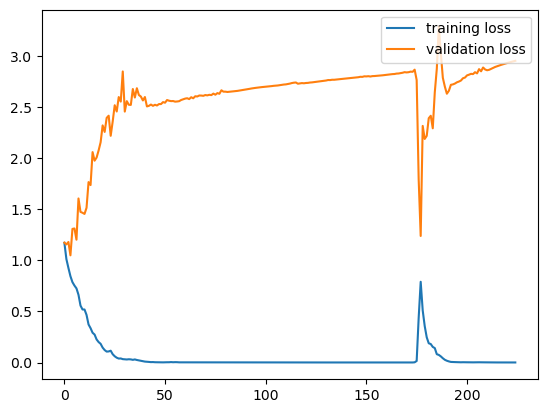

cd3
3822


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0436 loss_val: 1.1152 time: 4.2731s
 Epoch: 0010 loss_train: 0.0421 loss_val: 1.3545 time: 4.6632s
 Epoch: 0020 loss_train: 0.0075 loss_val: 1.5390 time: 4.8128s
 Epoch: 0030 loss_train: 0.0203 loss_val: 1.6449 time: 4.5860s
 Epoch: 0040 loss_train: 0.0893 loss_val: 1.7467 time: 5.3987s
 Epoch: 0050 loss_train: 0.0036 loss_val: 1.5989 time: 4.3413s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.6160 time: 5.4249s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.6263 time: 4.7634s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.6370 time: 6.8717s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6474 time: 5.6857s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6573 time: 5.4544s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6667 time: 5.4010s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6757 time: 6.5873s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6844 time: 6.1326s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6930 time: 5.9054s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.7012 time: 

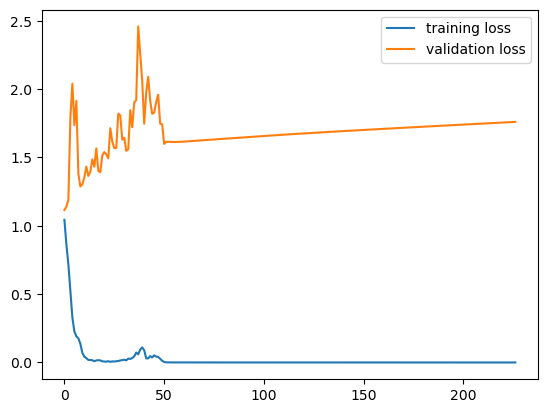

cd4
5637


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2094 loss_val: 1.3968 time: 8.4633s
 Epoch: 0010 loss_train: 0.3537 loss_val: 1.5688 time: 7.8847s
 Epoch: 0020 loss_train: 0.1313 loss_val: 1.8438 time: 6.2739s
 Epoch: 0030 loss_train: 0.0300 loss_val: 2.2183 time: 7.8150s
 Epoch: 0040 loss_train: 0.0081 loss_val: 2.1082 time: 7.3360s
 Epoch: 0050 loss_train: 0.0044 loss_val: 2.1442 time: 8.1343s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.1510 time: 7.6249s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.1847 time: 9.2723s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.2096 time: 6.6759s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.2323 time: 7.8025s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.2592 time: 7.9230s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.2706 time: 7.4571s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.3003 time: 6.9141s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.3170 time: 7.1961s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.3331 time: 8.0529s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.3702 time: 

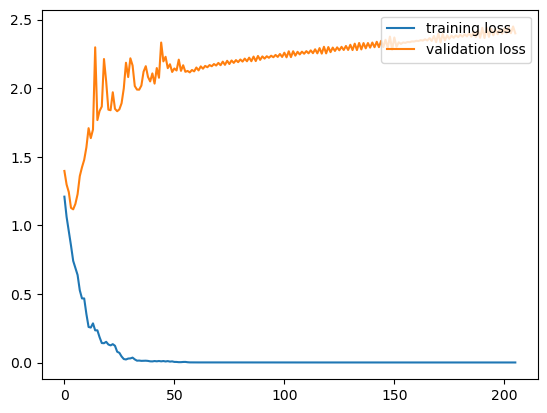

cd8
5659


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2161 loss_val: 1.6210 time: 7.4846s
 Epoch: 0010 loss_train: 0.1823 loss_val: 1.6760 time: 7.5670s
 Epoch: 0020 loss_train: 0.0077 loss_val: 1.8190 time: 7.0606s
 Epoch: 0030 loss_train: 0.0020 loss_val: 1.9163 time: 7.4063s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.9725 time: 8.0728s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0193 time: 8.5292s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0577 time: 6.9348s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.0907 time: 6.5397s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1201 time: 7.5310s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.1471 time: 7.6654s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1724 time: 7.9062s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1959 time: 7.9751s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2184 time: 6.1892s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2400 time: 8.8317s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2611 time: 9.3671s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2814 time: 

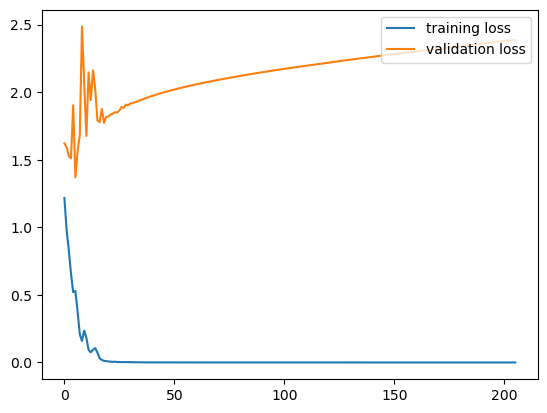

gh2ax
4938


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0377 loss_val: 1.6131 time: 6.3927s
 Epoch: 0010 loss_train: 0.0086 loss_val: 1.1153 time: 7.4205s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1914 time: 5.4066s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2319 time: 6.9512s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2637 time: 6.8987s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2903 time: 6.4660s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3135 time: 6.8589s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3341 time: 6.9654s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3530 time: 7.5687s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3704 time: 7.0083s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3868 time: 7.2231s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4022 time: 5.9956s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4169 time: 5.1479s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4310 time: 6.9510s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4447 time: 7.1631s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4579 time: 

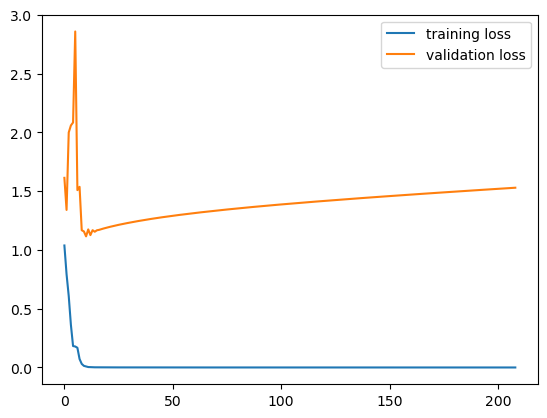

lamin
4939


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1720 loss_val: 1.4410 time: 6.8629s
 Epoch: 0010 loss_train: 0.1226 loss_val: 1.5701 time: 5.3685s
 Epoch: 0020 loss_train: 0.0074 loss_val: 1.3347 time: 7.9040s
 Epoch: 0030 loss_train: 0.0078 loss_val: 1.4787 time: 5.9008s
 Epoch: 0040 loss_train: 0.0639 loss_val: 1.8052 time: 5.2626s
 Epoch: 0050 loss_train: 0.0010 loss_val: 1.5656 time: 4.2518s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.5776 time: 7.8375s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.5981 time: 5.4768s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.6152 time: 5.3710s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.6302 time: 7.3634s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6437 time: 6.5622s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6564 time: 4.0863s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6685 time: 4.5754s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6799 time: 8.0650s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6910 time: 7.8937s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.7017 time: 

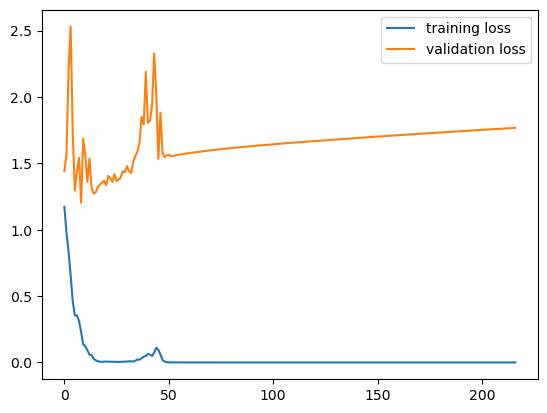

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
cd16
4555


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1203 loss_val: 1.2115 time: 9.2294s
 Epoch: 0010 loss_train: 0.4355 loss_val: 1.5478 time: 6.5668s
 Epoch: 0020 loss_train: 0.1691 loss_val: 2.1136 time: 7.3148s
 Epoch: 0030 loss_train: 0.0296 loss_val: 2.6162 time: 6.2149s
 Epoch: 0040 loss_train: 0.0198 loss_val: 2.6141 time: 6.8835s
 Epoch: 0050 loss_train: 0.0374 loss_val: 2.9346 time: 7.1465s
 Epoch: 0060 loss_train: 0.0065 loss_val: 2.7385 time: 8.0980s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.6747 time: 8.1051s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.7283 time: 7.0979s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.7637 time: 7.2513s
 Epoch: 0100 loss_train: 0.0002 loss_val: 2.7918 time: 6.8124s
 Epoch: 0110 loss_train: 0.0002 loss_val: 2.8164 time: 5.4071s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.8384 time: 6.8330s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.8589 time: 6.7280s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.8782 time: 5.5120s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.8968 time: 

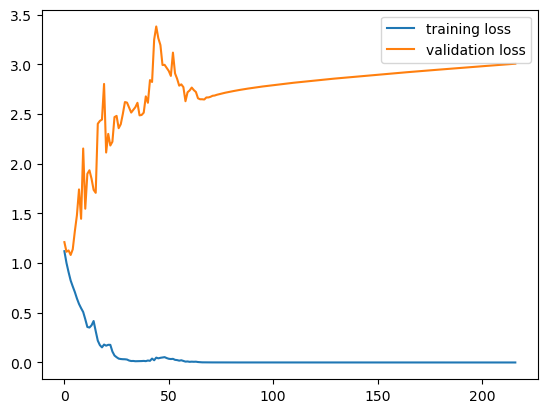

cd3
3760


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0279 loss_val: 1.1202 time: 6.2648s
 Epoch: 0010 loss_train: 0.0947 loss_val: 1.9441 time: 5.4900s
 Epoch: 0020 loss_train: 0.0058 loss_val: 1.3004 time: 5.8527s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.2646 time: 6.0083s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.2941 time: 4.9150s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.3189 time: 4.3005s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3405 time: 5.6754s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3597 time: 5.4305s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3771 time: 6.7739s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.3931 time: 6.0044s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4080 time: 5.2688s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4219 time: 6.7347s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4350 time: 5.5164s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4476 time: 5.7354s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4596 time: 6.7971s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4712 time: 

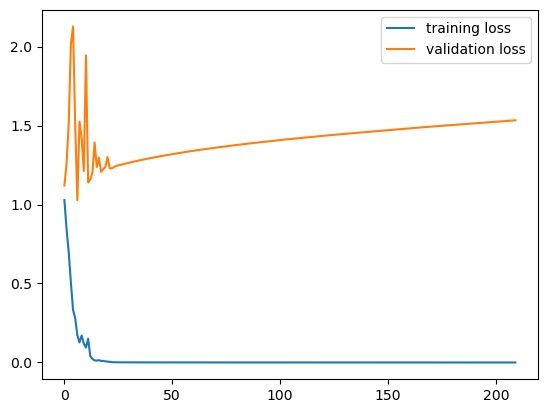

cd4
5580


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1967 loss_val: 1.4491 time: 8.1767s
 Epoch: 0010 loss_train: 0.3419 loss_val: 1.8019 time: 7.3334s
 Epoch: 0020 loss_train: 0.1295 loss_val: 1.8365 time: 7.8046s
 Epoch: 0030 loss_train: 0.0151 loss_val: 2.3181 time: 10.0470s
 Epoch: 0040 loss_train: 0.0153 loss_val: 2.3946 time: 8.0945s
 Epoch: 0050 loss_train: 0.0066 loss_val: 2.4869 time: 8.9928s
 Epoch: 0060 loss_train: 0.0015 loss_val: 2.5789 time: 9.5219s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.5462 time: 9.8803s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.5669 time: 7.2414s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.5865 time: 7.8364s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6052 time: 7.6322s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6230 time: 7.5049s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6403 time: 7.5852s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6570 time: 7.3403s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6735 time: 6.6139s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.6898 time:

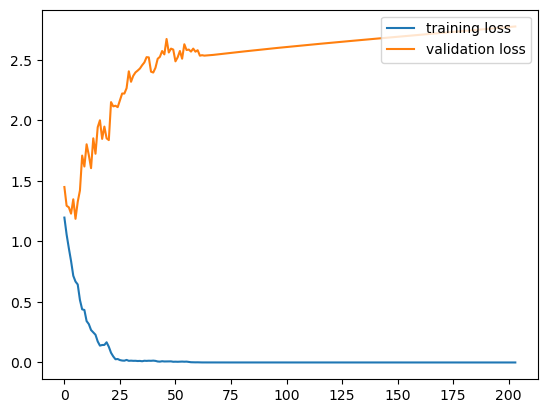

cd8
5604


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1900 loss_val: 1.8275 time: 7.1627s
 Epoch: 0010 loss_train: 0.1179 loss_val: 1.6864 time: 7.9451s
 Epoch: 0020 loss_train: 0.0164 loss_val: 2.0150 time: 6.8345s
 Epoch: 0030 loss_train: 0.0028 loss_val: 2.0221 time: 8.8584s
 Epoch: 0040 loss_train: 0.0019 loss_val: 2.0911 time: 6.6279s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.1514 time: 8.7682s
 Epoch: 0060 loss_train: 0.0010 loss_val: 2.1912 time: 9.0410s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.2259 time: 8.2005s
 Epoch: 0080 loss_train: 0.0009 loss_val: 2.2623 time: 6.5248s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.2906 time: 7.5479s
 Epoch: 0100 loss_train: 0.0008 loss_val: 2.3186 time: 7.1478s
 Epoch: 0110 loss_train: 0.0295 loss_val: 2.2285 time: 8.1159s
 Epoch: 0120 loss_train: 0.0143 loss_val: 2.2830 time: 6.6484s
 Epoch: 0130 loss_train: 0.0024 loss_val: 2.3719 time: 9.1132s
 Epoch: 0140 loss_train: 0.0013 loss_val: 2.4461 time: 7.7067s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.4969 time: 

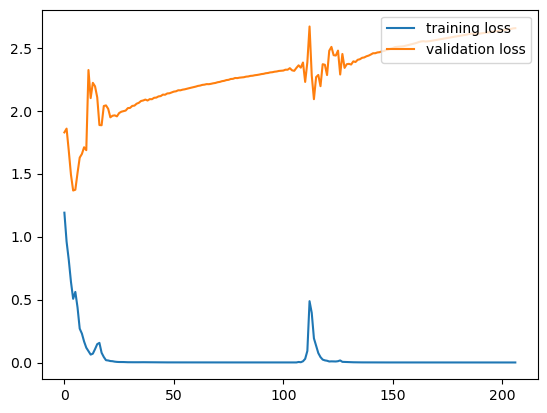

gh2ax
4837


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0079 loss_val: 1.8347 time: 7.9475s
 Epoch: 0010 loss_train: 0.0117 loss_val: 1.0088 time: 7.0858s
 Epoch: 0020 loss_train: 0.0009 loss_val: 0.9689 time: 7.5381s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.0028 time: 5.7468s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.0292 time: 6.4170s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.0512 time: 7.9001s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.0704 time: 4.7866s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.0874 time: 6.5386s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1030 time: 5.8402s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1173 time: 6.7560s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.1308 time: 7.3076s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.1434 time: 4.8266s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.1555 time: 6.6215s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.1669 time: 7.7651s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.1780 time: 6.2075s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.1887 time: 

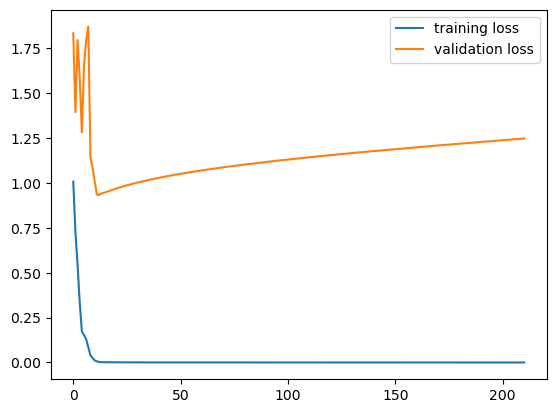

lamin
4838


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1297 loss_val: 1.7930 time: 7.6912s
 Epoch: 0010 loss_train: 0.0966 loss_val: 1.1520 time: 7.0631s
 Epoch: 0020 loss_train: 0.0120 loss_val: 1.2806 time: 6.6283s
 Epoch: 0030 loss_train: 0.0129 loss_val: 1.3293 time: 6.0545s
 Epoch: 0040 loss_train: 0.0110 loss_val: 1.5144 time: 7.3069s
 Epoch: 0050 loss_train: 0.0184 loss_val: 1.4428 time: 4.9911s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.3745 time: 5.6338s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.3949 time: 5.8100s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4127 time: 4.7392s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4279 time: 5.5588s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4417 time: 6.5877s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4542 time: 7.3255s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4660 time: 6.7773s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4771 time: 6.3563s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4876 time: 7.6693s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4976 time: 

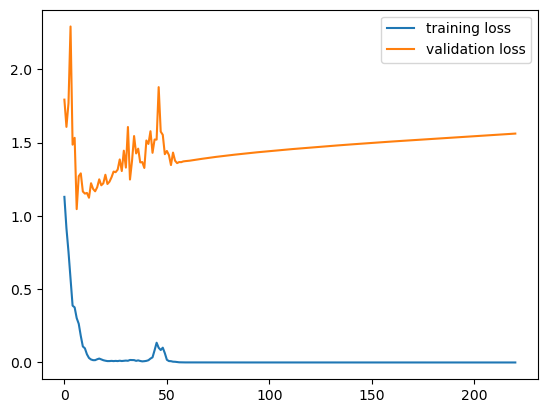

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
cd16
4490


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1482 loss_val: 1.2122 time: 7.9141s
 Epoch: 0010 loss_train: 0.5214 loss_val: 1.8108 time: 6.7588s
 Epoch: 0020 loss_train: 0.1640 loss_val: 3.3190 time: 7.0504s
 Epoch: 0030 loss_train: 0.0180 loss_val: 2.4211 time: 6.3531s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.4519 time: 6.1851s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.4823 time: 6.8190s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.5105 time: 8.2641s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.5360 time: 6.8680s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.5592 time: 6.9291s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.5811 time: 5.6003s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6018 time: 7.0202s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6215 time: 5.9953s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6407 time: 7.0786s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6591 time: 7.4550s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6772 time: 7.7006s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.6948 time: 

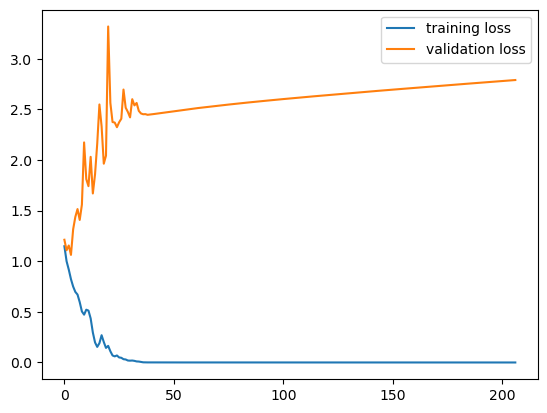

cd3
3802


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0154 loss_val: 1.1007 time: 5.8057s
 Epoch: 0010 loss_train: 0.0900 loss_val: 1.0470 time: 5.7355s
 Epoch: 0020 loss_train: 0.0015 loss_val: 1.1054 time: 6.6125s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.1472 time: 3.8370s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.1798 time: 5.0975s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.2061 time: 5.0219s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2284 time: 4.6268s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2480 time: 5.3722s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2655 time: 5.8405s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.2813 time: 5.0948s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2960 time: 5.3860s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3099 time: 6.1093s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3228 time: 4.0385s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3351 time: 6.6206s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3468 time: 6.5762s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3580 time: 

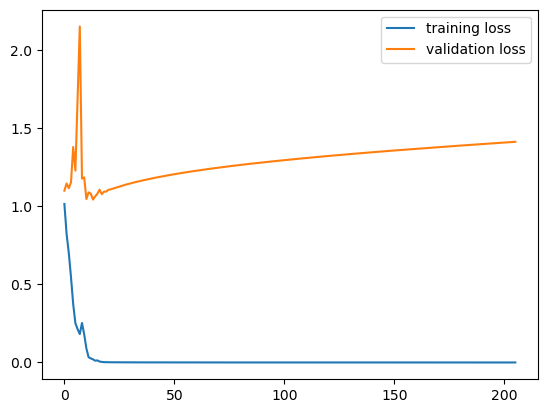

cd4
5518


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1787 loss_val: 1.5168 time: 8.0407s
 Epoch: 0010 loss_train: 0.4185 loss_val: 1.5161 time: 7.8903s
 Epoch: 0020 loss_train: 0.1074 loss_val: 2.2907 time: 6.9946s
 Epoch: 0030 loss_train: 0.0053 loss_val: 2.2957 time: 7.5760s
 Epoch: 0040 loss_train: 0.0143 loss_val: 2.6196 time: 8.4809s
 Epoch: 0050 loss_train: 0.0321 loss_val: 2.7165 time: 8.0552s
 Epoch: 0060 loss_train: 0.0435 loss_val: 2.6983 time: 7.4114s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.6661 time: 8.8052s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6825 time: 8.1700s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.7010 time: 8.3983s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.7178 time: 7.0652s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.7339 time: 8.1591s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7493 time: 7.0218s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7643 time: 7.2096s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.7790 time: 7.2967s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.7932 time: 

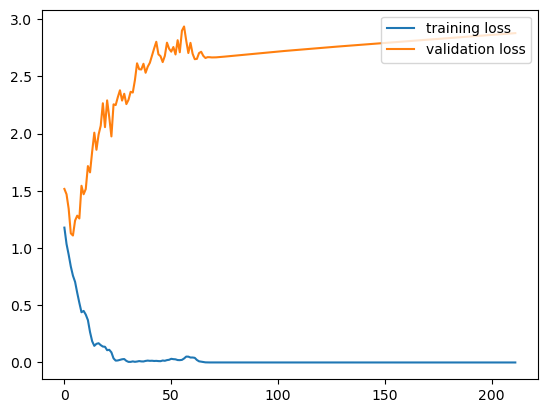

cd8
5545


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2015 loss_val: 1.5690 time: 8.0256s
 Epoch: 0010 loss_train: 0.0896 loss_val: 1.9359 time: 4.9000s
 Epoch: 0020 loss_train: 0.0022 loss_val: 1.9724 time: 7.2639s
 Epoch: 0030 loss_train: 0.0007 loss_val: 2.0043 time: 7.0881s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0438 time: 7.7286s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0793 time: 6.7435s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1112 time: 7.0269s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1403 time: 6.6461s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1673 time: 7.9053s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1926 time: 6.5220s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2166 time: 7.2410s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2396 time: 7.4127s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2618 time: 7.9788s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2832 time: 7.4145s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3038 time: 7.7048s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3240 time: 

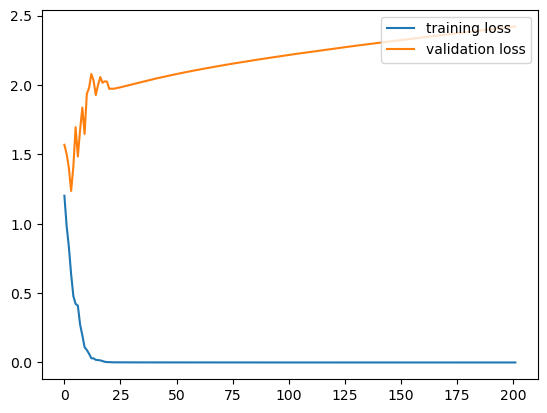

gh2ax
4931


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0095 loss_val: 1.8345 time: 5.5181s
 Epoch: 0010 loss_train: 0.0099 loss_val: 1.1364 time: 5.8644s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.1214 time: 7.0083s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.1604 time: 7.2759s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1899 time: 6.3485s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2144 time: 6.8160s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2357 time: 6.3181s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2547 time: 6.7691s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2721 time: 7.0410s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2882 time: 7.0922s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3033 time: 6.6554s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3175 time: 5.9352s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3309 time: 7.3560s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.3440 time: 6.9193s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3567 time: 7.7690s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3689 time: 

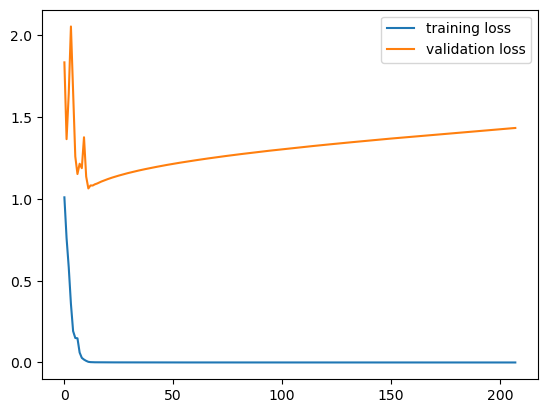

lamin
4932


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1897 loss_val: 2.1314 time: 7.4490s
 Epoch: 0010 loss_train: 0.1192 loss_val: 1.1399 time: 8.2551s
 Epoch: 0020 loss_train: 0.0287 loss_val: 1.5336 time: 6.1542s
 Epoch: 0030 loss_train: 0.0096 loss_val: 1.4608 time: 6.5777s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.3806 time: 6.8336s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3839 time: 6.1432s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3996 time: 6.6271s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4143 time: 6.3709s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4280 time: 6.1129s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4410 time: 5.7099s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4533 time: 5.5907s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4649 time: 6.4800s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4765 time: 8.3596s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4875 time: 6.1907s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4984 time: 6.3049s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5090 time: 

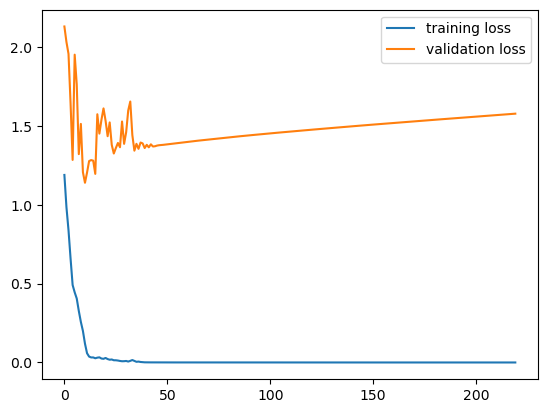

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
cd16
4629


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1700 loss_val: 1.1651 time: 7.2424s
 Epoch: 0010 loss_train: 0.5163 loss_val: 1.5427 time: 6.4509s
 Epoch: 0020 loss_train: 0.2145 loss_val: 2.2842 time: 6.6914s
 Epoch: 0030 loss_train: 0.0237 loss_val: 2.4382 time: 5.8543s
 Epoch: 0040 loss_train: 0.0045 loss_val: 2.4865 time: 5.2958s
 Epoch: 0050 loss_train: 0.0034 loss_val: 2.5236 time: 5.9419s
 Epoch: 0060 loss_train: 0.0023 loss_val: 2.5370 time: 5.9941s
 Epoch: 0070 loss_train: 0.0020 loss_val: 2.5752 time: 5.6005s
 Epoch: 0080 loss_train: 0.0019 loss_val: 2.6018 time: 6.2379s
 Epoch: 0090 loss_train: 0.0022 loss_val: 2.6221 time: 7.4013s
 Epoch: 0100 loss_train: 0.0018 loss_val: 2.6459 time: 7.3673s
 Epoch: 0110 loss_train: 0.0015 loss_val: 2.6776 time: 6.2452s
 Epoch: 0120 loss_train: 0.0047 loss_val: 2.6826 time: 4.8216s
 Epoch: 0130 loss_train: 0.0044 loss_val: 2.7677 time: 5.5455s
 Epoch: 0140 loss_train: 0.0016 loss_val: 2.7788 time: 7.0080s
 Epoch: 0150 loss_train: 0.0013 loss_val: 2.8174 time: 

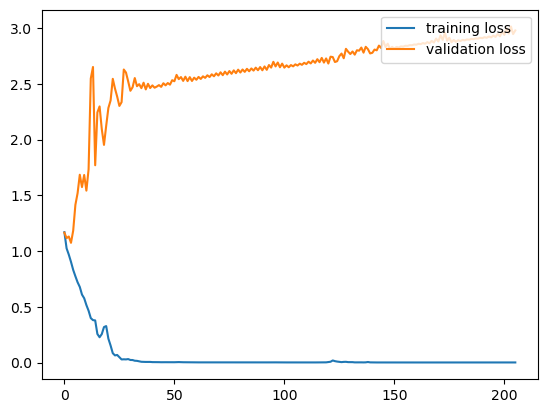

cd3
3806


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0134 loss_val: 1.1123 time: 5.0878s
 Epoch: 0010 loss_train: 0.0309 loss_val: 1.1612 time: 5.0750s
 Epoch: 0020 loss_train: 0.0181 loss_val: 1.6646 time: 6.4159s
 Epoch: 0030 loss_train: 0.0226 loss_val: 1.7129 time: 4.8246s
 Epoch: 0040 loss_train: 0.1899 loss_val: 1.8517 time: 5.0453s
 Epoch: 0050 loss_train: 0.0006 loss_val: 1.5154 time: 4.8967s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5416 time: 4.7033s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.5623 time: 4.1059s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5797 time: 5.8642s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5948 time: 6.6714s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6086 time: 4.5988s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6212 time: 5.0102s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6331 time: 4.3391s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6442 time: 4.8542s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6548 time: 5.7394s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6650 time: 

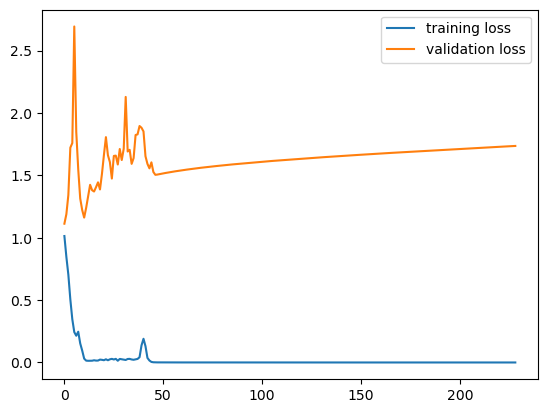

cd4
5663


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1896 loss_val: 1.4767 time: 7.5220s
 Epoch: 0010 loss_train: 0.3818 loss_val: 1.6732 time: 7.0036s
 Epoch: 0020 loss_train: 0.1594 loss_val: 1.9899 time: 6.0292s
 Epoch: 0030 loss_train: 0.0063 loss_val: 2.2997 time: 8.1525s
 Epoch: 0040 loss_train: 0.0013 loss_val: 2.3906 time: 6.2331s
 Epoch: 0050 loss_train: 0.0007 loss_val: 2.4298 time: 8.7090s
 Epoch: 0060 loss_train: 0.0005 loss_val: 2.4640 time: 5.6181s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.4925 time: 6.8651s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.5239 time: 9.5508s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.5477 time: 5.9359s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.5820 time: 8.3555s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.5921 time: 5.0701s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.6230 time: 6.9485s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.6398 time: 6.8252s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.6643 time: 7.9866s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.6856 time: 

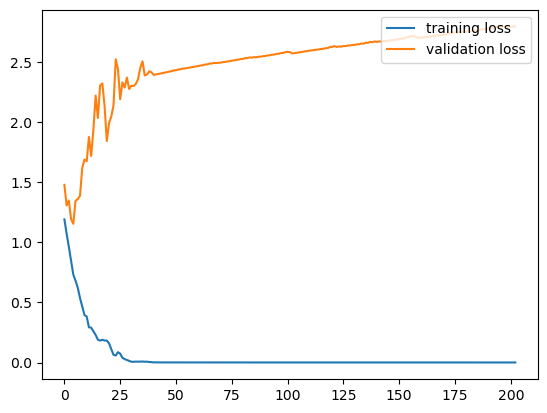

cd8
5687


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2393 loss_val: 1.7310 time: 8.4542s
 Epoch: 0010 loss_train: 0.1242 loss_val: 1.8408 time: 6.9697s
 Epoch: 0020 loss_train: 0.0100 loss_val: 1.9992 time: 6.4526s
 Epoch: 0030 loss_train: 0.0024 loss_val: 2.0555 time: 7.4045s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.1188 time: 6.6205s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1704 time: 6.7352s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2116 time: 7.2189s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2471 time: 6.6112s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2787 time: 8.9760s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.3077 time: 7.1540s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3346 time: 8.2342s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3600 time: 7.3687s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3844 time: 6.6838s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4078 time: 7.4510s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4304 time: 5.3905s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4523 time: 

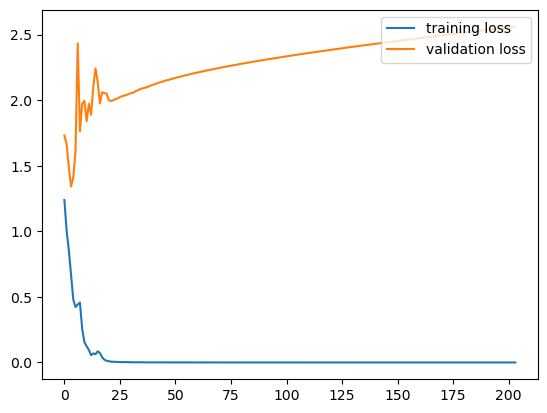

gh2ax
4889


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0826 loss_val: 1.4424 time: 6.6303s
 Epoch: 0010 loss_train: 0.0141 loss_val: 1.0327 time: 8.7758s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.1348 time: 6.6031s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.1749 time: 7.4096s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2053 time: 6.1158s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2304 time: 5.6547s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2521 time: 8.0609s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2714 time: 6.9055s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2890 time: 8.7717s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3053 time: 9.0762s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3206 time: 6.8445s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3349 time: 6.2728s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3486 time: 5.7115s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3618 time: 4.5719s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3744 time: 7.5124s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3867 time: 

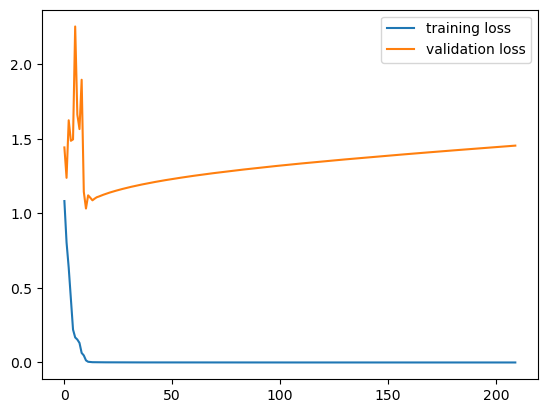

lamin
4890


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1953 loss_val: 1.3983 time: 6.2591s
 Epoch: 0010 loss_train: 0.1363 loss_val: 1.3071 time: 8.3278s
 Epoch: 0020 loss_train: 0.0248 loss_val: 1.4231 time: 5.3812s
 Epoch: 0030 loss_train: 0.0192 loss_val: 2.3779 time: 7.6048s
 Epoch: 0040 loss_train: 0.0149 loss_val: 1.6907 time: 4.4414s
 Epoch: 0050 loss_train: 0.0006 loss_val: 1.4553 time: 7.5272s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4763 time: 6.8601s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4957 time: 5.2811s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5121 time: 8.7684s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5267 time: 7.3015s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5402 time: 8.7018s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5528 time: 9.3100s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5648 time: 3.8460s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5764 time: 7.2236s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5876 time: 5.5094s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5984 time: 

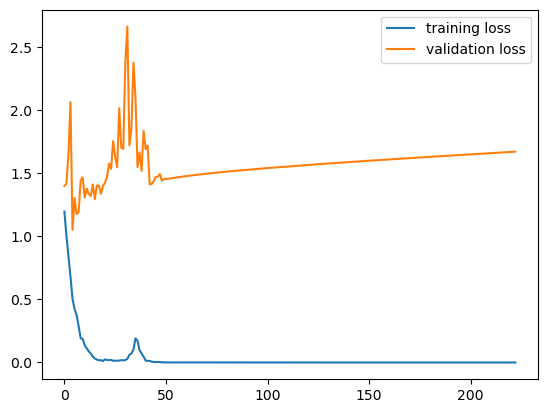

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
cd16
4560


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1545 loss_val: 1.2508 time: 6.6364s
 Epoch: 0010 loss_train: 0.4288 loss_val: 1.8686 time: 7.4207s
 Epoch: 0020 loss_train: 0.1366 loss_val: 1.9692 time: 4.9853s
 Epoch: 0030 loss_train: 0.0301 loss_val: 2.4120 time: 5.3256s
 Epoch: 0040 loss_train: 0.0486 loss_val: 2.4375 time: 6.9425s
 Epoch: 0050 loss_train: 0.0047 loss_val: 2.4332 time: 6.5368s
 Epoch: 0060 loss_train: 0.0018 loss_val: 2.4449 time: 6.5782s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.4838 time: 4.9614s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.5164 time: 6.5965s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.5399 time: 6.4615s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.5636 time: 6.5884s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.5855 time: 8.4610s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.5931 time: 5.6949s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.6212 time: 6.6069s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.6414 time: 5.1351s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.6576 time: 

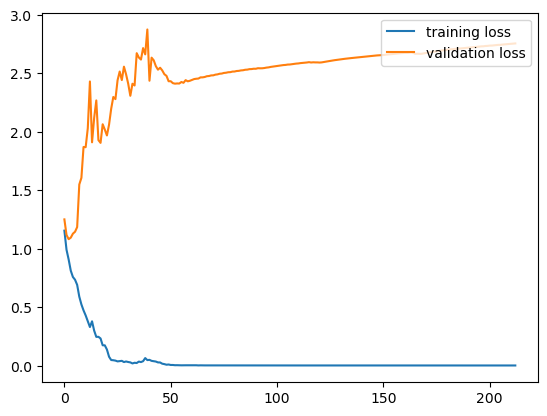

cd3
3772


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0410 loss_val: 1.0993 time: 5.3924s
 Epoch: 0010 loss_train: 0.1289 loss_val: 1.2937 time: 6.5463s
 Epoch: 0020 loss_train: 0.0086 loss_val: 1.3374 time: 5.4384s
 Epoch: 0030 loss_train: 0.0009 loss_val: 1.3431 time: 5.8540s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3699 time: 5.4076s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3909 time: 6.6034s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4092 time: 6.0807s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4256 time: 5.8900s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4407 time: 6.6372s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4547 time: 6.1323s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4680 time: 5.9733s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4805 time: 6.3111s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4924 time: 6.1211s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5037 time: 6.2811s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5149 time: 6.4892s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5256 time: 

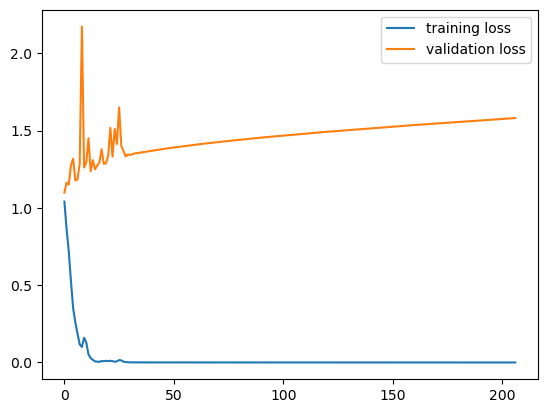

cd4
5602


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2112 loss_val: 1.4513 time: 9.5324s
 Epoch: 0010 loss_train: 0.2776 loss_val: 1.5827 time: 9.5024s
 Epoch: 0020 loss_train: 0.0798 loss_val: 1.9099 time: 8.4897s
 Epoch: 0030 loss_train: 0.0055 loss_val: 2.2298 time: 9.3672s
 Epoch: 0040 loss_train: 0.0009 loss_val: 2.2226 time: 6.8217s
 Epoch: 0050 loss_train: 0.0007 loss_val: 2.2600 time: 8.5387s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.2942 time: 9.2315s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.3251 time: 8.7696s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.3512 time: 7.3982s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.3794 time: 7.2675s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.4029 time: 6.7780s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.4302 time: 8.9312s
 Epoch: 0120 loss_train: 0.3183 loss_val: 2.1741 time: 9.8266s
 Epoch: 0130 loss_train: 0.0056 loss_val: 2.3713 time: 9.0346s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.4418 time: 7.1737s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.4942 time: 

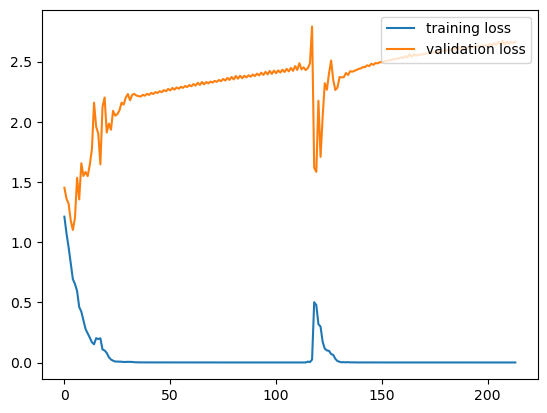

cd8
5625


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2372 loss_val: 1.7528 time: 9.2633s
 Epoch: 0010 loss_train: 0.1411 loss_val: 1.9491 time: 9.3284s
 Epoch: 0020 loss_train: 0.0123 loss_val: 2.0450 time: 9.5503s
 Epoch: 0030 loss_train: 0.0018 loss_val: 1.9200 time: 6.8369s
 Epoch: 0040 loss_train: 0.0016 loss_val: 1.9783 time: 8.5774s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.0305 time: 9.6514s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.0708 time: 9.1916s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.1076 time: 6.7261s
 Epoch: 0080 loss_train: 0.0053 loss_val: 2.1579 time: 8.1825s
 Epoch: 0090 loss_train: 0.0034 loss_val: 2.1305 time: 7.3322s
 Epoch: 0100 loss_train: 0.0010 loss_val: 2.1887 time: 8.0247s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.2086 time: 9.0412s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.2518 time: 8.3328s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.2903 time: 7.8416s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.3083 time: 7.1174s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.3446 time: 

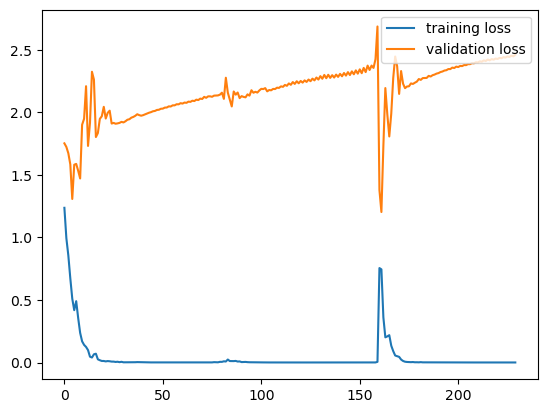

gh2ax
4892


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0548 loss_val: 1.4703 time: 5.7293s
 Epoch: 0010 loss_train: 0.0062 loss_val: 1.2126 time: 6.6075s
 Epoch: 0020 loss_train: 0.0035 loss_val: 1.2674 time: 5.9314s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2740 time: 6.3696s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3022 time: 8.7968s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3255 time: 7.3980s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3460 time: 7.5320s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3645 time: 6.8210s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3816 time: 6.1804s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3975 time: 6.1570s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4126 time: 5.4663s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4269 time: 7.4504s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4407 time: 6.5113s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4539 time: 8.2072s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4665 time: 6.5720s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4789 time: 

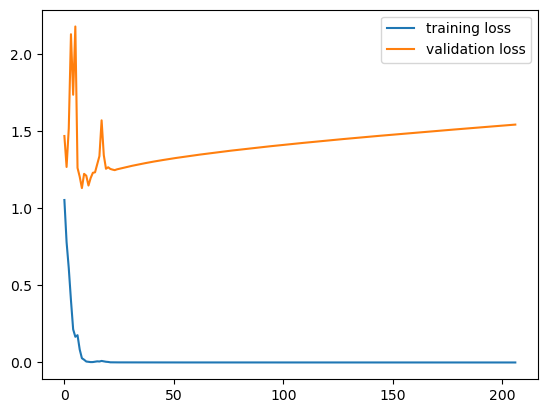

lamin
4893


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1894 loss_val: 1.5477 time: 6.4284s
 Epoch: 0010 loss_train: 0.2376 loss_val: 1.2639 time: 7.5692s
 Epoch: 0020 loss_train: 0.0127 loss_val: 1.3305 time: 6.5471s
 Epoch: 0030 loss_train: 0.0027 loss_val: 1.3563 time: 5.5595s
 Epoch: 0040 loss_train: 0.0006 loss_val: 1.3991 time: 6.9703s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4191 time: 7.3226s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4393 time: 5.9479s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4576 time: 7.2947s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4740 time: 7.7018s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4893 time: 6.8302s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5036 time: 7.5591s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5175 time: 6.4927s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5307 time: 6.7779s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5434 time: 8.3748s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5557 time: 6.7861s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5677 time: 

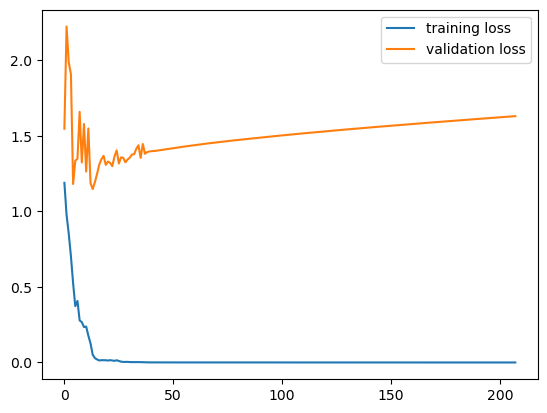

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
28
cd16
4544


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1375 loss_val: 1.1831 time: 7.4260s
 Epoch: 0010 loss_train: 0.4661 loss_val: 1.4853 time: 7.6778s
 Epoch: 0020 loss_train: 0.1261 loss_val: 2.1945 time: 6.9884s
 Epoch: 0030 loss_train: 0.0280 loss_val: 2.4366 time: 7.0981s
 Epoch: 0040 loss_train: 0.0183 loss_val: 2.7473 time: 7.9528s
 Epoch: 0050 loss_train: 0.0389 loss_val: 2.7846 time: 6.8736s
 Epoch: 0060 loss_train: 0.0237 loss_val: 2.6950 time: 7.7595s
 Epoch: 0070 loss_train: 0.0029 loss_val: 2.5833 time: 8.1808s
 Epoch: 0080 loss_train: 0.0026 loss_val: 2.6291 time: 8.3089s
 Epoch: 0090 loss_train: 0.0019 loss_val: 2.6863 time: 8.1203s
 Epoch: 0100 loss_train: 0.0017 loss_val: 2.6965 time: 7.3943s
 Epoch: 0110 loss_train: 0.0017 loss_val: 2.7273 time: 7.5318s
 Epoch: 0120 loss_train: 0.0014 loss_val: 2.7316 time: 6.6624s
 Epoch: 0130 loss_train: 0.0015 loss_val: 2.7745 time: 7.2799s
 Epoch: 0140 loss_train: 0.0016 loss_val: 2.7752 time: 8.2614s
 Epoch: 0150 loss_train: 0.0014 loss_val: 2.7724 time: 

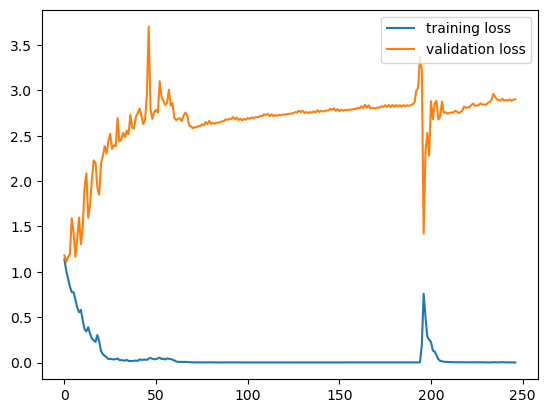

cd3
3781


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0323 loss_val: 1.0988 time: 5.2374s
 Epoch: 0010 loss_train: 0.0227 loss_val: 1.1820 time: 6.0389s
 Epoch: 0020 loss_train: 0.0057 loss_val: 1.3770 time: 5.9713s
 Epoch: 0030 loss_train: 0.0392 loss_val: 1.7118 time: 5.5153s
 Epoch: 0040 loss_train: 0.0310 loss_val: 1.6974 time: 7.3854s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.4955 time: 7.1303s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5032 time: 6.4314s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5136 time: 4.7182s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5238 time: 5.6034s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5336 time: 4.8752s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5431 time: 5.7487s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5523 time: 6.9834s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5612 time: 5.1882s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5699 time: 6.6527s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5785 time: 6.3990s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5868 time: 

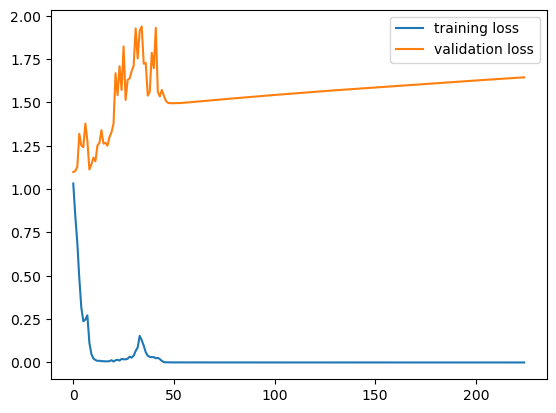

cd4
5579


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2119 loss_val: 1.7067 time: 7.0193s
 Epoch: 0010 loss_train: 0.3353 loss_val: 1.6237 time: 9.6278s
 Epoch: 0020 loss_train: 0.0963 loss_val: 2.2027 time: 7.1974s
 Epoch: 0030 loss_train: 0.0151 loss_val: 2.3428 time: 7.2512s
 Epoch: 0040 loss_train: 0.0102 loss_val: 2.3091 time: 9.3431s
 Epoch: 0050 loss_train: 0.0066 loss_val: 2.5763 time: 10.2660s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.4087 time: 6.9190s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4308 time: 9.4925s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4536 time: 8.7615s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4748 time: 7.5557s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4948 time: 10.5558s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.5141 time: 7.7912s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5329 time: 8.9696s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5512 time: 8.6787s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5691 time: 8.6863s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5867 time

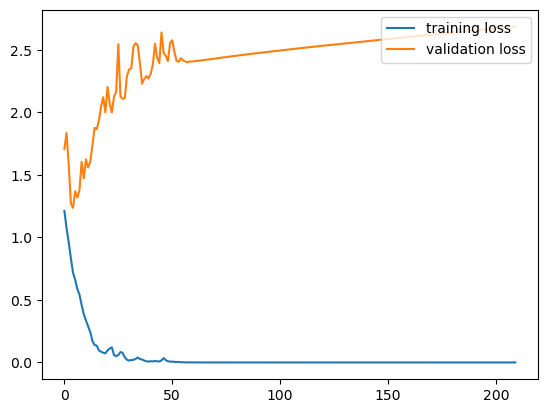

cd8
5605


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1959 loss_val: 1.6364 time: 11.3293s
 Epoch: 0010 loss_train: 0.1633 loss_val: 1.6071 time: 8.3145s
 Epoch: 0020 loss_train: 0.0228 loss_val: 2.0397 time: 9.6271s
 Epoch: 0030 loss_train: 0.0027 loss_val: 2.0736 time: 8.5917s
 Epoch: 0040 loss_train: 0.0009 loss_val: 2.1159 time: 8.0559s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.1617 time: 9.6705s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.1962 time: 9.8994s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.2378 time: 10.8265s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.2570 time: 9.5390s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.2937 time: 8.4724s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.3251 time: 9.4039s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3455 time: 8.0854s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.3891 time: 8.5648s
 Epoch: 0130 loss_train: 0.2462 loss_val: 1.9404 time: 9.3425s
 Epoch: 0140 loss_train: 0.0063 loss_val: 2.2712 time: 8.8525s
 Epoch: 0150 loss_train: 0.0007 loss_val: 2.3360 time

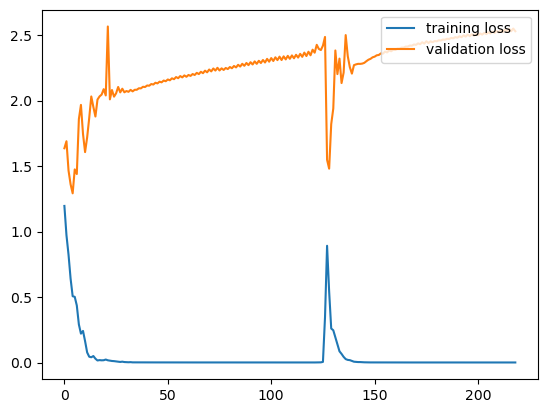

gh2ax
4926


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0364 loss_val: 1.7710 time: 7.6078s
 Epoch: 0010 loss_train: 0.0241 loss_val: 1.3425 time: 7.4003s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.1980 time: 8.6787s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2353 time: 7.6944s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2636 time: 7.9417s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2875 time: 7.7945s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3083 time: 8.4681s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3271 time: 8.0735s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3444 time: 7.8640s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3604 time: 6.5353s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3756 time: 7.4818s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3899 time: 8.2712s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4038 time: 7.5070s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.4171 time: 8.0271s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4300 time: 8.5880s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4426 time: 

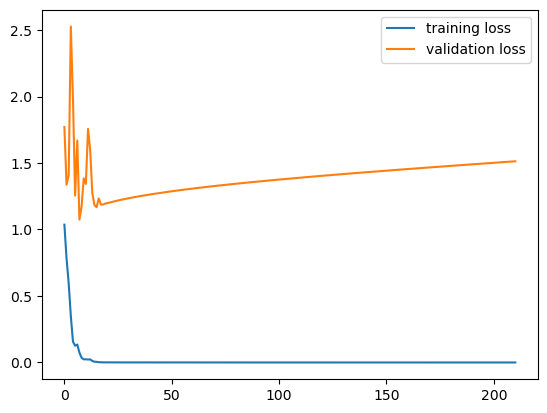

lamin
4927


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2103 loss_val: 1.6441 time: 8.7268s
 Epoch: 0010 loss_train: 0.2370 loss_val: 1.3866 time: 8.9467s
 Epoch: 0020 loss_train: 0.0224 loss_val: 1.3150 time: 6.6200s
 Epoch: 0030 loss_train: 0.0165 loss_val: 1.5888 time: 8.4179s
 Epoch: 0040 loss_train: 0.1116 loss_val: 1.8521 time: 8.9643s
 Epoch: 0050 loss_train: 0.0016 loss_val: 1.3795 time: 7.8816s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.4109 time: 7.4158s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.4310 time: 8.9945s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4471 time: 7.9065s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4611 time: 8.3369s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4736 time: 7.7328s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4852 time: 8.5593s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4960 time: 8.2528s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5062 time: 7.3328s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5161 time: 8.2840s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5255 time: 

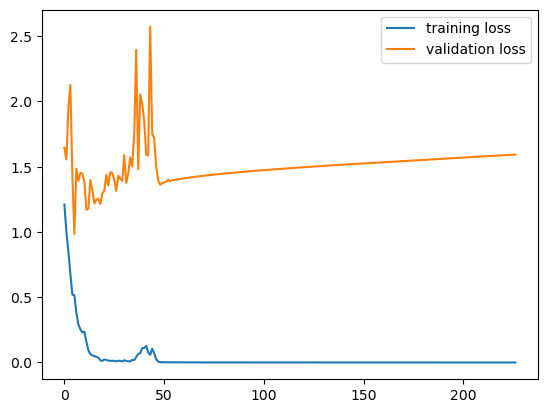

29
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
29
cd16
4608


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1390 loss_val: 1.1628 time: 9.7961s
 Epoch: 0010 loss_train: 0.4385 loss_val: 1.7686 time: 8.2451s
 Epoch: 0020 loss_train: 0.1279 loss_val: 2.3480 time: 8.8043s
 Epoch: 0030 loss_train: 0.0299 loss_val: 2.5613 time: 7.6623s
 Epoch: 0040 loss_train: 0.0148 loss_val: 2.6009 time: 8.1079s
 Epoch: 0050 loss_train: 0.0111 loss_val: 2.7349 time: 7.4998s
 Epoch: 0060 loss_train: 0.0034 loss_val: 2.5975 time: 8.3487s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.6386 time: 7.3663s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.6836 time: 6.4837s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.7097 time: 8.2043s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.7372 time: 6.1299s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.7554 time: 9.0398s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.7797 time: 7.7404s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.7914 time: 8.0150s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.8117 time: 7.5518s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.8301 time: 

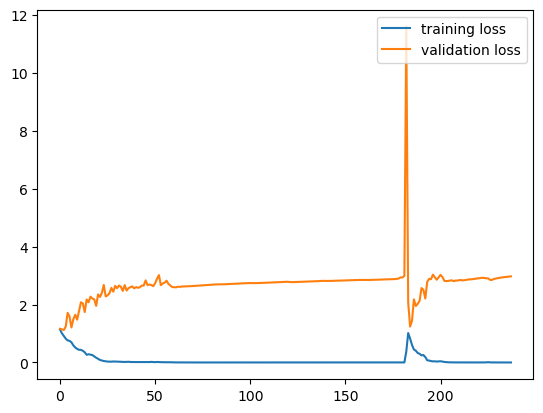

cd3
3822


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0242 loss_val: 1.0845 time: 6.0505s
 Epoch: 0010 loss_train: 0.0425 loss_val: 1.1666 time: 6.5699s
 Epoch: 0020 loss_train: 0.0257 loss_val: 1.7302 time: 5.7509s
 Epoch: 0030 loss_train: 0.0221 loss_val: 1.7288 time: 6.7754s
 Epoch: 0040 loss_train: 0.0331 loss_val: 2.0624 time: 7.8235s
 Epoch: 0050 loss_train: 0.0151 loss_val: 1.6578 time: 6.9686s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.5757 time: 4.3133s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.5901 time: 6.0653s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.6027 time: 7.0722s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.6140 time: 7.1920s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6241 time: 7.7312s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6336 time: 7.5654s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6426 time: 6.6863s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6512 time: 6.0118s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6596 time: 7.1345s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6677 time: 

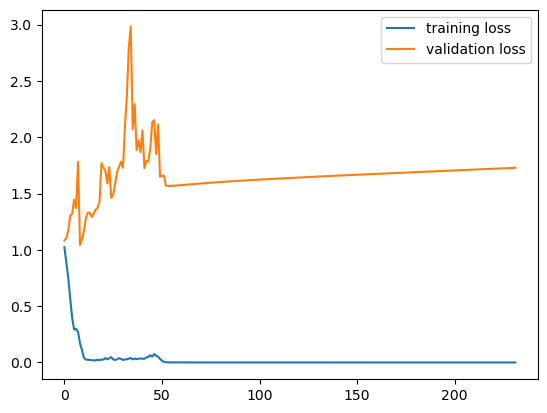

cd4
5637


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2039 loss_val: 1.4178 time: 11.2114s
 Epoch: 0010 loss_train: 0.3459 loss_val: 1.5109 time: 8.3605s
 Epoch: 0020 loss_train: 0.0977 loss_val: 2.2182 time: 10.1183s
 Epoch: 0030 loss_train: 0.0092 loss_val: 2.0640 time: 10.8592s
 Epoch: 0040 loss_train: 0.0008 loss_val: 2.1671 time: 11.1340s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.2111 time: 10.5181s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2484 time: 10.8940s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2805 time: 10.9817s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.3093 time: 9.8151s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3362 time: 8.0504s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3616 time: 12.3356s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3858 time: 11.5202s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4090 time: 10.1043s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4318 time: 10.3987s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4539 time: 10.7872s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2

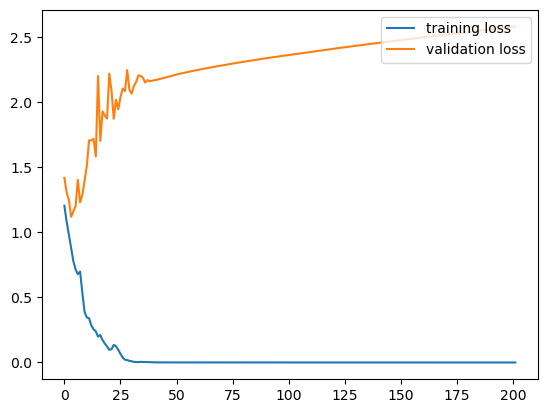

cd8
5659


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1997 loss_val: 1.6235 time: 8.3167s
 Epoch: 0010 loss_train: 0.0980 loss_val: 2.2524 time: 9.8000s
 Epoch: 0020 loss_train: 0.0032 loss_val: 1.8884 time: 8.4115s
 Epoch: 0030 loss_train: 0.0014 loss_val: 1.9898 time: 9.9235s
 Epoch: 0040 loss_train: 0.0011 loss_val: 2.0512 time: 11.5994s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0969 time: 8.6675s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1365 time: 7.5198s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.1707 time: 9.5434s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2011 time: 9.9658s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2291 time: 10.2008s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2551 time: 9.4261s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2793 time: 10.2824s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3026 time: 9.5323s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3251 time: 9.6384s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3467 time: 8.0156s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3679 tim

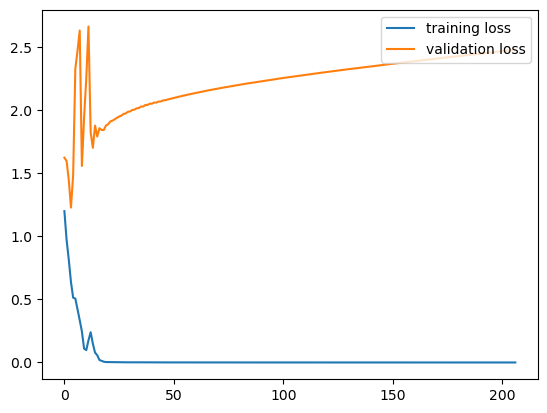

gh2ax
4938


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0339 loss_val: 1.7320 time: 9.0670s
 Epoch: 0010 loss_train: 0.0176 loss_val: 1.2154 time: 9.2291s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2450 time: 7.8202s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2839 time: 9.2604s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3146 time: 9.7773s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3405 time: 8.9940s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3634 time: 10.4141s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3839 time: 10.9569s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4025 time: 9.9629s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4198 time: 9.7484s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4361 time: 10.5713s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4517 time: 10.3981s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4665 time: 10.7058s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4807 time: 10.2601s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4944 time: 10.9368s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5078

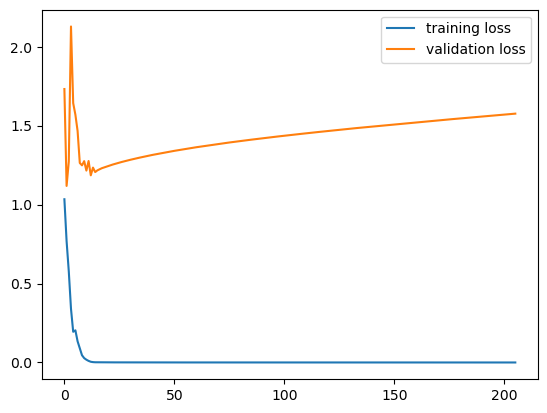

lamin
4939


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2048 loss_val: 1.5281 time: 8.7375s
 Epoch: 0010 loss_train: 0.1364 loss_val: 1.3861 time: 9.9306s
 Epoch: 0020 loss_train: 0.0196 loss_val: 1.4397 time: 9.7395s
 Epoch: 0030 loss_train: 0.0085 loss_val: 1.5508 time: 9.8491s
 Epoch: 0040 loss_train: 0.0099 loss_val: 1.6775 time: 10.4517s
 Epoch: 0050 loss_train: 0.0010 loss_val: 1.6711 time: 10.3173s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.6423 time: 9.3828s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.6506 time: 8.9438s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.6601 time: 8.2999s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6698 time: 10.3391s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6795 time: 8.2743s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6894 time: 8.0074s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6992 time: 9.2446s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.7090 time: 10.5343s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.7185 time: 9.1415s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.7282 ti

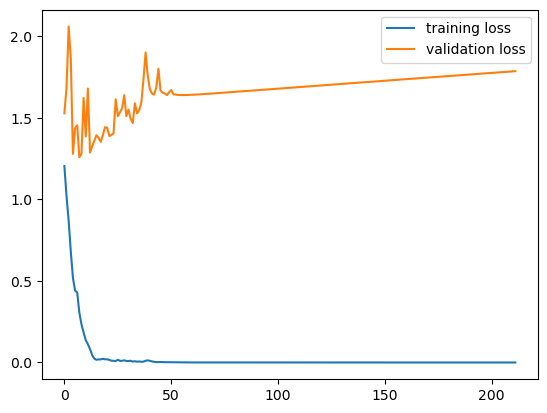

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
cd16
4555


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1395 loss_val: 1.2020 time: 10.3976s
 Epoch: 0010 loss_train: 0.4226 loss_val: 1.6541 time: 9.8552s
 Epoch: 0020 loss_train: 0.1587 loss_val: 2.1758 time: 9.9868s
 Epoch: 0030 loss_train: 0.0522 loss_val: 2.5036 time: 9.2604s
 Epoch: 0040 loss_train: 0.0348 loss_val: 2.7949 time: 10.2145s
 Epoch: 0050 loss_train: 0.0035 loss_val: 2.5649 time: 9.8640s
 Epoch: 0060 loss_train: 0.0017 loss_val: 2.5751 time: 9.4292s
 Epoch: 0070 loss_train: 0.0012 loss_val: 2.6034 time: 9.1397s
 Epoch: 0080 loss_train: 0.0013 loss_val: 2.6284 time: 9.4149s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.6490 time: 10.3596s
 Epoch: 0100 loss_train: 0.0011 loss_val: 2.6683 time: 10.9098s
 Epoch: 0110 loss_train: 0.0009 loss_val: 2.6841 time: 9.3509s
 Epoch: 0120 loss_train: 0.0010 loss_val: 2.7035 time: 9.4966s
 Epoch: 0130 loss_train: 0.0009 loss_val: 2.7169 time: 8.4308s
 Epoch: 0140 loss_train: 0.0010 loss_val: 2.7325 time: 9.5715s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.7466 ti

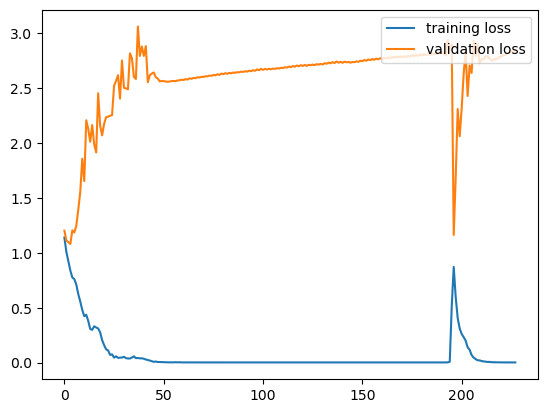

cd3
3760


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0380 loss_val: 1.1069 time: 7.5613s
 Epoch: 0010 loss_train: 0.0579 loss_val: 1.5512 time: 8.0509s
 Epoch: 0020 loss_train: 0.0402 loss_val: 1.6902 time: 7.8467s
 Epoch: 0030 loss_train: 0.0336 loss_val: 2.1233 time: 7.5547s
 Epoch: 0040 loss_train: 0.0137 loss_val: 1.7200 time: 8.5828s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4033 time: 8.1417s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4143 time: 9.1764s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4250 time: 7.4993s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4349 time: 8.0256s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4445 time: 8.7238s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4536 time: 8.2342s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4625 time: 9.0961s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4711 time: 8.1643s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4793 time: 6.5959s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4875 time: 7.7157s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4955 time: 

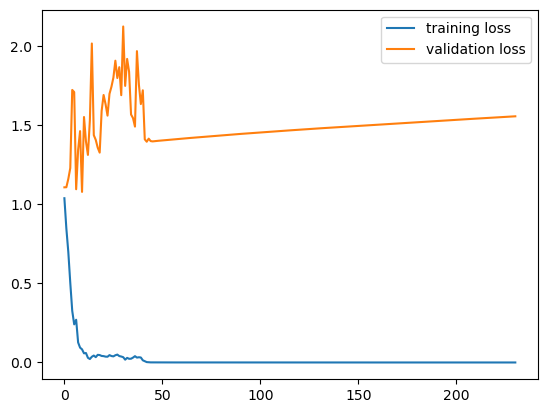

cd4
5580


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1957 loss_val: 1.4883 time: 10.6638s
 Epoch: 0010 loss_train: 0.3685 loss_val: 1.7345 time: 11.1725s
 Epoch: 0020 loss_train: 0.0974 loss_val: 2.2072 time: 11.3618s
 Epoch: 0030 loss_train: 0.0128 loss_val: 2.2486 time: 11.7195s
 Epoch: 0040 loss_train: 0.0007 loss_val: 2.2676 time: 10.6342s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.3175 time: 12.3005s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.3568 time: 11.5589s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3901 time: 12.4282s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4201 time: 12.7797s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.4475 time: 12.8961s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4733 time: 12.5661s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4977 time: 10.9878s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5213 time: 11.3116s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5440 time: 11.4211s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5658 time: 11.7843s
 Epoch: 0150 loss_train: 0.0001 loss_val

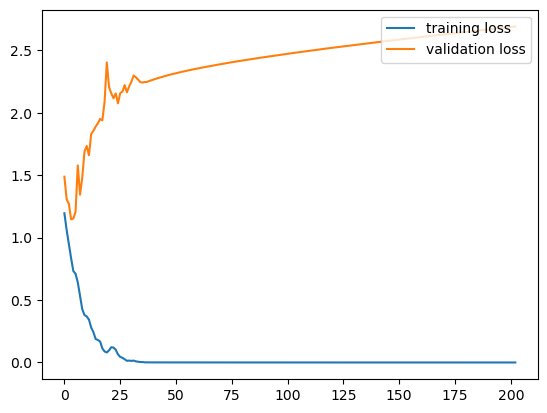

cd8
5604


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1856 loss_val: 1.7651 time: 10.8233s
 Epoch: 0010 loss_train: 0.1450 loss_val: 1.8802 time: 11.5098s
 Epoch: 0020 loss_train: 0.0111 loss_val: 2.2014 time: 10.8084s
 Epoch: 0030 loss_train: 0.0261 loss_val: 2.4865 time: 10.7491s
 Epoch: 0040 loss_train: 0.0040 loss_val: 2.2107 time: 12.4503s
 Epoch: 0050 loss_train: 0.0015 loss_val: 2.1942 time: 11.7669s
 Epoch: 0060 loss_train: 0.0015 loss_val: 2.2234 time: 12.7306s
 Epoch: 0070 loss_train: 0.0014 loss_val: 2.2487 time: 12.7968s
 Epoch: 0080 loss_train: 0.0013 loss_val: 2.2699 time: 11.5040s
 Epoch: 0090 loss_train: 0.0012 loss_val: 2.2884 time: 11.2907s
 Epoch: 0100 loss_train: 0.0013 loss_val: 2.3175 time: 12.3644s
 Epoch: 0110 loss_train: 0.0011 loss_val: 2.3283 time: 12.9473s
 Epoch: 0120 loss_train: 0.0011 loss_val: 2.3508 time: 11.1541s
 Epoch: 0130 loss_train: 0.0011 loss_val: 2.4037 time: 11.9896s
 Epoch: 0140 loss_train: 0.0011 loss_val: 2.4002 time: 11.8426s
 Epoch: 0150 loss_train: 0.0012 loss_val

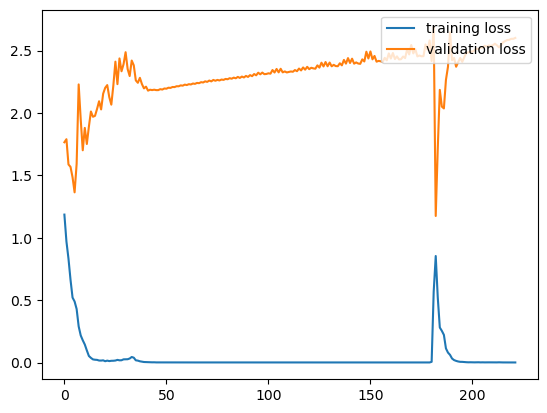

gh2ax
4837


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0286 loss_val: 1.6907 time: 9.5655s
 Epoch: 0010 loss_train: 0.0186 loss_val: 1.0539 time: 8.4830s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.0157 time: 9.3807s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.0487 time: 10.2526s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.0746 time: 9.5418s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.0964 time: 9.5158s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1153 time: 8.6581s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.1323 time: 7.9865s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1478 time: 8.3296s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1622 time: 8.3681s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.1756 time: 8.8094s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.1883 time: 9.2959s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2004 time: 8.2717s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.2120 time: 8.9073s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.2231 time: 9.1748s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.2339 time:

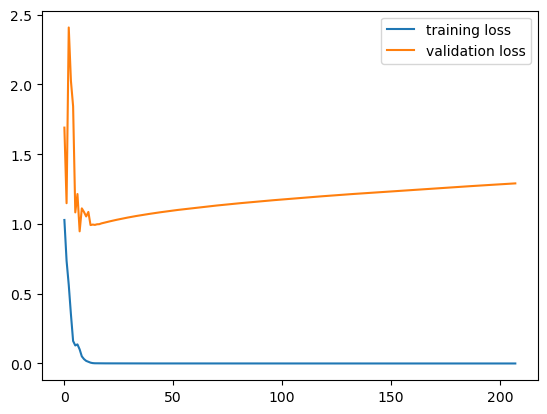

lamin
4838


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1437 loss_val: 1.5592 time: 9.5283s
 Epoch: 0010 loss_train: 0.0758 loss_val: 1.1690 time: 8.8115s
 Epoch: 0020 loss_train: 0.0167 loss_val: 1.3258 time: 8.1625s
 Epoch: 0030 loss_train: 0.0139 loss_val: 1.2957 time: 9.1883s
 Epoch: 0040 loss_train: 0.1038 loss_val: 1.8855 time: 8.1749s
 Epoch: 0050 loss_train: 0.0010 loss_val: 1.3616 time: 9.1697s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3720 time: 7.5404s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3889 time: 8.7391s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4025 time: 9.7346s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4145 time: 9.1974s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4253 time: 9.8230s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4356 time: 9.6370s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4453 time: 8.1835s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4546 time: 9.7184s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4637 time: 8.9926s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4724 time: 

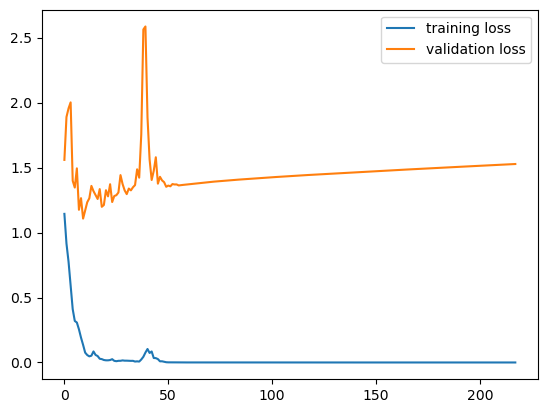

31
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
31
cd16
4490


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1590 loss_val: 1.1945 time: 9.8239s
 Epoch: 0010 loss_train: 0.4639 loss_val: 1.6422 time: 10.7780s
 Epoch: 0020 loss_train: 0.1775 loss_val: 2.5683 time: 10.1922s
 Epoch: 0030 loss_train: 0.0124 loss_val: 2.4921 time: 9.9528s
 Epoch: 0040 loss_train: 0.0014 loss_val: 2.5090 time: 9.6367s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.5343 time: 10.3128s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.5639 time: 10.5316s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.5913 time: 9.3811s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6166 time: 11.3706s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.6403 time: 11.1266s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6629 time: 8.2665s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6845 time: 8.4178s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7054 time: 10.2283s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7255 time: 10.8691s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.7450 time: 9.5799s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.764

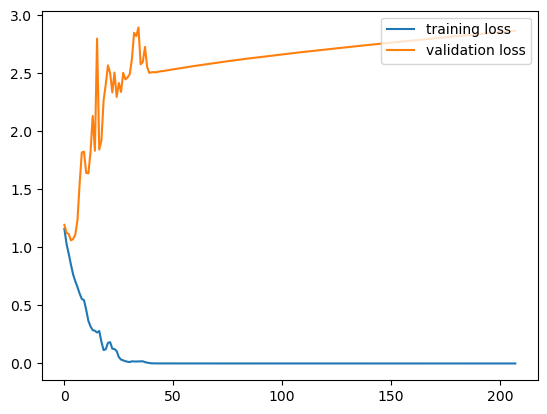

cd3
3802


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9905 loss_val: 1.0853 time: 7.8590s
 Epoch: 0010 loss_train: 0.0555 loss_val: 1.2170 time: 7.8258s
 Epoch: 0020 loss_train: 0.0042 loss_val: 1.2476 time: 7.0957s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2365 time: 6.6161s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2579 time: 8.0474s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2765 time: 5.8995s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2933 time: 6.7391s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3083 time: 7.5614s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3221 time: 6.1323s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3349 time: 6.4239s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3469 time: 7.2045s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3584 time: 7.9463s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3694 time: 7.1083s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3799 time: 7.6193s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3901 time: 7.8759s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3998 time: 

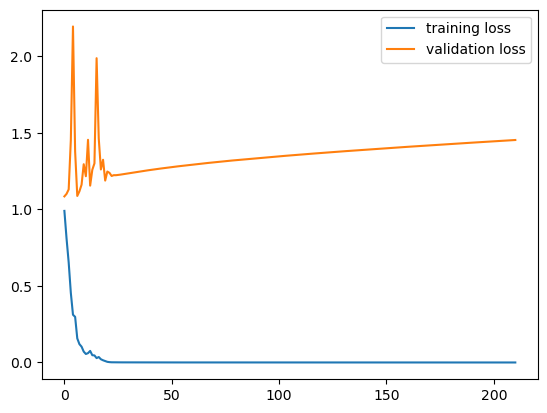

cd4
5518


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1939 loss_val: 1.4260 time: 10.8710s
 Epoch: 0010 loss_train: 0.4677 loss_val: 1.4046 time: 10.5626s
 Epoch: 0020 loss_train: 0.1202 loss_val: 2.1371 time: 10.9048s
 Epoch: 0030 loss_train: 0.0065 loss_val: 2.3396 time: 10.8119s
 Epoch: 0040 loss_train: 0.0157 loss_val: 2.5101 time: 11.4987s
 Epoch: 0050 loss_train: 0.0136 loss_val: 2.7790 time: 11.7728s
 Epoch: 0060 loss_train: 0.0774 loss_val: 2.6871 time: 10.0914s
 Epoch: 0070 loss_train: 0.0015 loss_val: 2.5887 time: 11.7573s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.5788 time: 11.5019s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.5953 time: 9.5987s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6109 time: 9.1930s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6254 time: 10.7742s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6397 time: 10.2687s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6532 time: 10.4762s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6664 time: 10.1550s
 Epoch: 0150 loss_train: 0.0000 loss_val: 

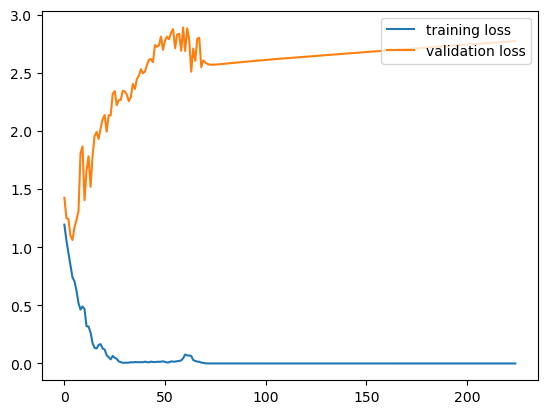

cd8
5545


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2152 loss_val: 1.6178 time: 10.6950s
 Epoch: 0010 loss_train: 0.1388 loss_val: 1.7369 time: 9.8006s
 Epoch: 0020 loss_train: 0.0014 loss_val: 1.9517 time: 9.9311s
 Epoch: 0030 loss_train: 0.0007 loss_val: 2.0224 time: 9.0612s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0738 time: 9.9602s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1155 time: 9.5248s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1516 time: 9.3376s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1839 time: 10.5753s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2132 time: 11.4035s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2405 time: 11.3066s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2660 time: 9.9713s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2902 time: 9.2773s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3133 time: 10.1596s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3354 time: 8.8868s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3568 time: 8.7611s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3778 t

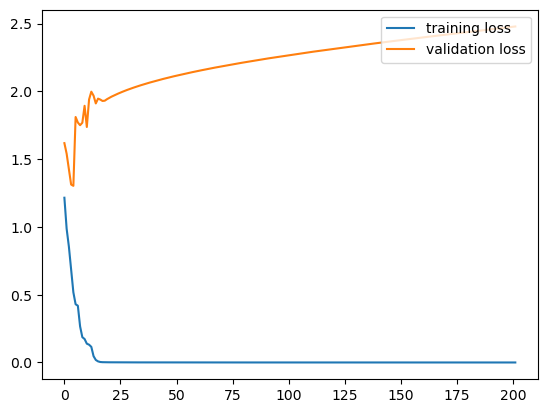

gh2ax
4931


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0034 loss_val: 2.0671 time: 7.2296s
 Epoch: 0010 loss_train: 0.0142 loss_val: 1.2624 time: 9.2262s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.0898 time: 9.0372s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.1258 time: 6.9251s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1533 time: 8.4882s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1762 time: 7.6951s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1962 time: 8.7527s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2143 time: 8.6521s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2308 time: 9.1324s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2462 time: 9.5450s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2607 time: 7.5400s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2744 time: 9.1328s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2878 time: 9.2398s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.3004 time: 9.4122s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3126 time: 9.4002s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3245 time: 

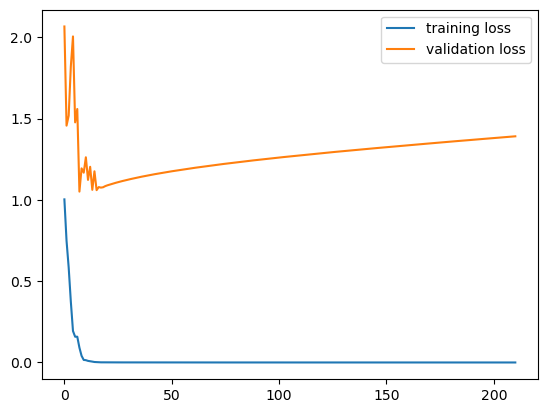

lamin
4932


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1956 loss_val: 1.7129 time: 7.9664s
 Epoch: 0010 loss_train: 0.1932 loss_val: 1.2945 time: 7.4147s
 Epoch: 0020 loss_train: 0.0150 loss_val: 1.2967 time: 9.6564s
 Epoch: 0030 loss_train: 0.0017 loss_val: 1.3098 time: 9.0288s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3535 time: 8.8359s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3773 time: 8.6490s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3974 time: 7.2967s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4154 time: 6.4990s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4318 time: 7.6687s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4474 time: 9.9553s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4618 time: 9.2347s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4755 time: 9.6662s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4888 time: 8.8740s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5014 time: 9.1966s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5138 time: 6.2493s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5257 time: 

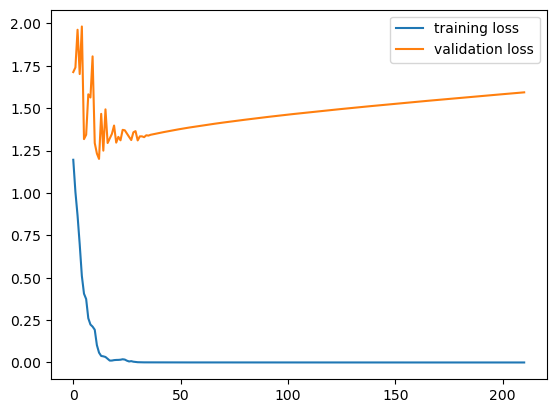

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
cd16
4629


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1415 loss_val: 1.1844 time: 9.2717s
 Epoch: 0010 loss_train: 0.4448 loss_val: 1.5944 time: 8.6548s
 Epoch: 0020 loss_train: 0.1489 loss_val: 2.2702 time: 8.6510s
 Epoch: 0030 loss_train: 0.0389 loss_val: 2.3774 time: 8.8165s
 Epoch: 0040 loss_train: 0.0100 loss_val: 2.5186 time: 8.7446s
 Epoch: 0050 loss_train: 0.0015 loss_val: 2.5128 time: 10.1895s
 Epoch: 0060 loss_train: 0.0005 loss_val: 2.5415 time: 8.4730s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.5803 time: 8.7375s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6109 time: 8.3992s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.6378 time: 9.4008s
 Epoch: 0100 loss_train: 0.0002 loss_val: 2.6622 time: 8.6493s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6850 time: 8.7131s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7062 time: 9.2376s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7267 time: 7.8661s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.7467 time: 9.5705s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.7660 time:

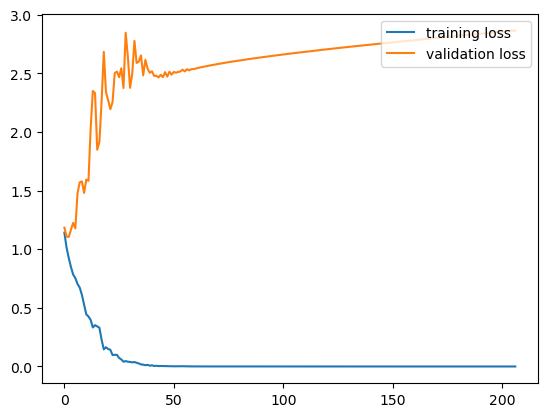

cd3
3806


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0228 loss_val: 1.0940 time: 7.6328s
 Epoch: 0010 loss_train: 0.0572 loss_val: 1.3466 time: 7.4264s
 Epoch: 0020 loss_train: 0.0431 loss_val: 1.8908 time: 7.2671s
 Epoch: 0030 loss_train: 0.0313 loss_val: 1.5615 time: 7.5692s
 Epoch: 0040 loss_train: 0.0470 loss_val: 2.1232 time: 7.1196s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.5787 time: 6.4310s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5803 time: 7.6229s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5870 time: 6.2560s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5943 time: 7.7440s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6018 time: 4.9709s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6092 time: 8.6216s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6164 time: 7.2127s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6237 time: 5.9807s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6308 time: 5.8745s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6378 time: 7.0250s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6448 time: 

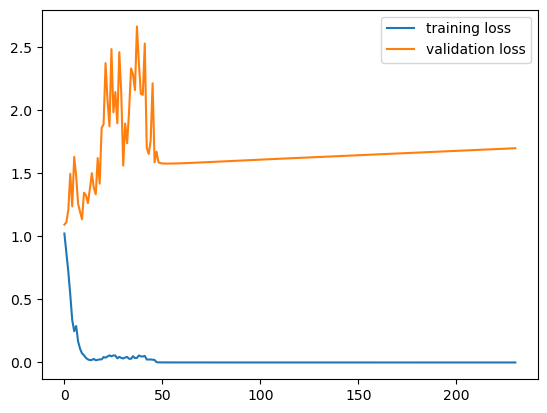

cd4
5663


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2177 loss_val: 1.4931 time: 11.0474s
 Epoch: 0010 loss_train: 0.3916 loss_val: 1.6220 time: 9.0796s
 Epoch: 0020 loss_train: 0.1036 loss_val: 2.1996 time: 11.2588s
 Epoch: 0030 loss_train: 0.0076 loss_val: 2.2630 time: 10.5365s
 Epoch: 0040 loss_train: 0.0025 loss_val: 2.3662 time: 8.8073s
 Epoch: 0050 loss_train: 0.0007 loss_val: 2.3909 time: 10.1490s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.4325 time: 9.2213s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.4615 time: 9.2765s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.4903 time: 9.4493s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.5216 time: 10.1128s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.5339 time: 10.1537s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.5641 time: 10.0726s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.5870 time: 9.8811s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.6185 time: 10.3631s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.6332 time: 9.5351s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.672

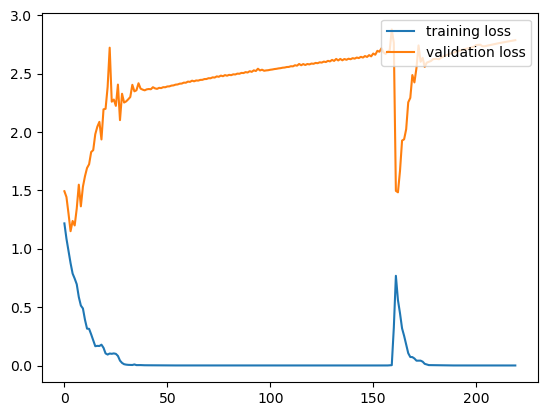

cd8
5687


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2165 loss_val: 1.7071 time: 7.8230s
 Epoch: 0010 loss_train: 0.1524 loss_val: 1.8395 time: 8.7495s
 Epoch: 0020 loss_train: 0.0182 loss_val: 2.0457 time: 9.8927s
 Epoch: 0030 loss_train: 0.0019 loss_val: 2.0174 time: 10.5225s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0765 time: 10.1054s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1209 time: 8.7868s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1564 time: 9.9935s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1869 time: 10.1317s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2146 time: 10.0564s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2401 time: 9.3364s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2639 time: 9.5143s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2865 time: 8.3726s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3082 time: 10.6177s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3290 time: 9.8316s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3493 time: 9.2044s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3692 t

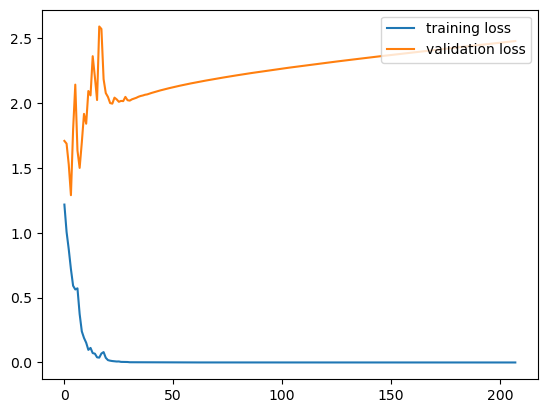

gh2ax
4889


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0603 loss_val: 1.5432 time: 8.3923s
 Epoch: 0010 loss_train: 0.0070 loss_val: 1.1400 time: 9.9863s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1861 time: 9.4081s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2255 time: 9.0225s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2564 time: 8.9349s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2820 time: 8.5114s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3043 time: 8.9746s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3241 time: 8.9549s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3422 time: 9.4738s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3590 time: 8.5228s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3748 time: 8.0891s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3896 time: 8.1625s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4039 time: 8.8829s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4174 time: 8.5940s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4307 time: 9.1589s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4435 time: 

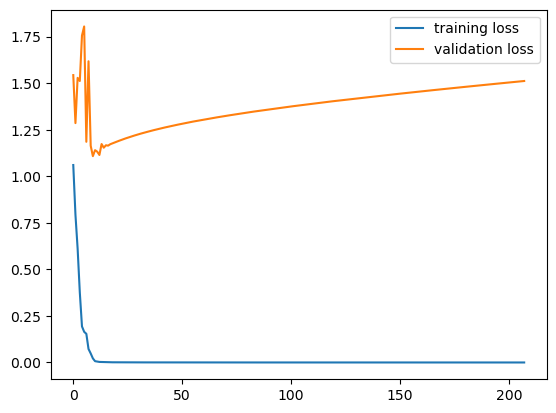

lamin
4890


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2061 loss_val: 1.4324 time: 6.4005s
 Epoch: 0010 loss_train: 0.1305 loss_val: 1.3591 time: 8.6147s
 Epoch: 0020 loss_train: 0.0063 loss_val: 1.4750 time: 9.0304s
 Epoch: 0030 loss_train: 0.0815 loss_val: 1.6745 time: 7.1381s
 Epoch: 0040 loss_train: 0.0050 loss_val: 1.5111 time: 7.2613s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.4956 time: 7.8858s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5061 time: 8.3130s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5199 time: 7.9643s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5327 time: 6.9037s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5449 time: 7.6692s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5565 time: 9.1311s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5677 time: 7.7037s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5785 time: 7.5184s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5890 time: 7.3602s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5993 time: 7.7522s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6092 time: 

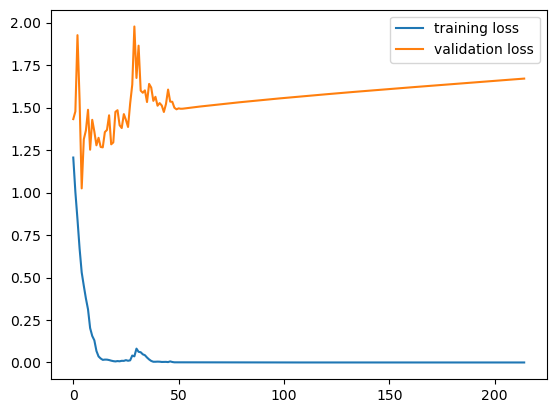

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
cd16
4560


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1542 loss_val: 1.1847 time: 8.5844s
 Epoch: 0010 loss_train: 0.5115 loss_val: 1.5642 time: 8.4862s
 Epoch: 0020 loss_train: 0.1288 loss_val: 2.2754 time: 9.5399s
 Epoch: 0030 loss_train: 0.0394 loss_val: 2.3334 time: 9.5419s
 Epoch: 0040 loss_train: 0.0141 loss_val: 2.4230 time: 9.8601s
 Epoch: 0050 loss_train: 0.0269 loss_val: 2.5648 time: 8.8085s
 Epoch: 0060 loss_train: 0.0041 loss_val: 2.4487 time: 8.8847s
 Epoch: 0070 loss_train: 0.0032 loss_val: 2.4552 time: 9.8164s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.4897 time: 9.2649s
 Epoch: 0090 loss_train: 0.0003 loss_val: 2.5340 time: 9.1064s
 Epoch: 0100 loss_train: 0.0002 loss_val: 2.5649 time: 9.0528s
 Epoch: 0110 loss_train: 0.0002 loss_val: 2.5904 time: 8.3620s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6131 time: 9.2741s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6339 time: 9.0969s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6533 time: 9.8383s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.6719 time: 

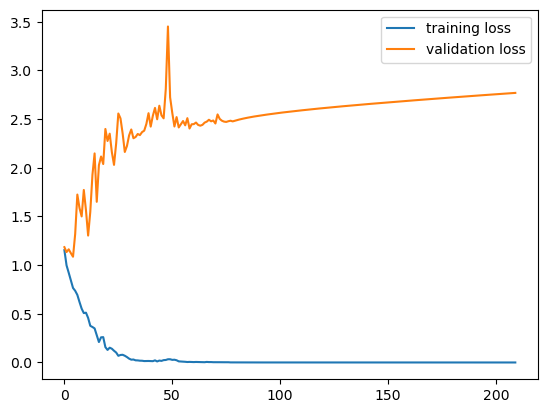

cd3
3772


/tmp/ipykernel_1555115/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555115/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0362 loss_val: 1.0904 time: 7.5660s
 Epoch: 0010 loss_train: 0.0522 loss_val: 1.4062 time: 6.9599s
 Epoch: 0020 loss_train: 0.0456 loss_val: 1.8897 time: 7.4868s
 Epoch: 0030 loss_train: 0.0732 loss_val: 2.4829 time: 8.5361s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.4948 time: 6.9828s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.5143 time: 7.0265s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5294 time: 7.9378s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5432 time: 8.3678s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5558 time: 7.5781s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5678 time: 6.8540s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5789 time: 7.8561s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5896 time: 6.3616s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5999 time: 7.5062s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6100 time: 8.1204s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6197 time: 7.1682s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6291 time: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
for sample_s in range(prevSampled,nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])
    
    
    print(sample_s)
    nProt=np.unique(proteinNames_samples_s).size
    pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
    plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()
    
    for p_curr in np.unique(proteinNames_samples_s):
        print(p_curr)
        print(np.sum(proteinNames_samples_s==p_curr))

        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        imgsC_all_curr=imgsC_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
        model.cuda()
        optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        #p2p - train samples
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgsC_all_curr.shape[0])).long()
        valIdx=np.arange(imgsC_all_curr.shape[0])
        p2p_res_train=np.zeros_like(imgsP_all_curr)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_p=torch.tensor(imgsP_all_curr[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

                recon_protein_shared=modelcnn_pShared_dec(reconShared_protein_l,pIDemb_dec(valInput_ID))
                p2p_res_train[valIdx_i]=recon_protein_shared.cpu().numpy()

        #p2p - validation samples
        imgP_p2p_target=imgsP_all_val_samples_s[p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_p2p_target.shape[0])).long()
        valIdx=np.arange(imgP_p2p_target.shape[0])

        p2p_res=np.zeros_like(imgP_p2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_p=torch.tensor(imgP_p2p_target[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

                recon_protein=modelcnn_pShared_dec(reconShared_protein_l,pIDemb_dec(valInput_ID))
                p2p_res[valIdx_i]=recon_protein.cpu().numpy()

        #train classifier
        train_loss=[np.inf]*epochs
        val_loss=[np.inf]*epochs

        t_ep=time.time()

        epCounts=0
        for ep in range(epochs):
            train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,p2p_res_train,p2p_res,torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

            if ep>50 and val_loss[ep]>=val_loss[ep-50]:
                epCounts+=1

            if epCounts>150:
                break


            if ep%saveFreq == (saveFreq-1):
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


            model.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))


        with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


        plt.plot(np.arange(epochs),train_loss)
        plt.plot(np.arange(epochs),val_loss)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
        plt.show()


### validation samples

In [13]:
for p_curr in np.unique(proteinNames_samples_s):
    print(p_curr)
    nconditions=np.unique(conditions_all_samples_s[proteinNames_samples_s==p_curr]).size
    res_val=np.zeros((nSamples,nconditions,nconditions))
    correctCount_val=[None]*nSamples
    
    for sample_s in range(nSamples):
        imgsC_all_samples_s=None
        imgsP_all_samples_s=None
        imgNames_all_samples_s=None
        proteinNames_samples_s=None
        pID_all_samples_s=None
        conditions_all_samples_s=None

        imgsC_all_val_samples_s={}
        imgsP_all_val_samples_s={}
        imgNames_all_val_samples_s={}
        proteinTrainInput_val_samples_s={}
        pID_all_val_samples_s={}
        conditions_all_val_samples_s={}
        for condition_i in conditions:
            print(condition_i)
            segDir_i=os.path.join(segDir,condition_i)
            imgDir_i=os.path.join(imgDir,condition_i)
            for stain in os.listdir(segDir_i):
                print(stain)
                segDir_i_stain=os.path.join(segDir_i,stain)
                imgDir_i_stain=os.path.join(imgDir_i,stain)

                segPID2name={}
                for pID_dir in os.listdir(segDir_i_stain):
                    pID=pID_dir.split('_')
                    segPID2name[pID[0]]=pID_dir
                imgPID2name={}
                for pID_dir in os.listdir(imgDir_i_stain):
                    pID=pID_dir.split('_')
                    imgPID2name[pID[0]]=pID_dir
                for pID in segPID2name.keys():
                    if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                        continue
                    if pID in holdOutSamples_samples[sample_s%6]:
                        print('hold out: '+pID)
                        continue
                    print(pID)
                    if pID not in imgPID2name:
                        print('img not found '+pID)
                        continue
                    imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                    segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                    with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                        imgNames=pickle.load(output)
                    with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                        img=pickle.load(output)

                    imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                    proteinNames_curr=np.array([])
                    stain_list=stain.split('_')
                    nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                    np.random.seed(sample_s+6)
                    allIdx_all=np.arange(img.shape[0])
                    np.random.shuffle(allIdx_all)
                    for s in range(1,len(stain_list)):
                        s_start=(s-1)*nImgPerStain
                        if s==len(stain_list)-1:
                            s_end=img.shape[0]
                        else:
                            s_end=s*nImgPerStain
                        imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                        proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                        #store other channels for validation
                        for sother in range(1,len(stain_list)):
                            if sother==s:
                                continue
                            if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                                pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                                imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                                imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                            else:
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                                pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                                imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                                imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                    if pID_all_samples_s is None:
                        pID_all_samples_s=np.repeat(pID,img.shape[0])
                        imgsC_all_samples_s=img[allIdx_all,[0]]
                        imgNames_all_samples_s=imgNames[allIdx_all]
                        proteinNames_samples_s=proteinNames_curr
                        imgsP_all_samples_s=imgP
                        conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                    else:
                        pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                        imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                        imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                        proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                        imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                        conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
        imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])


        print(sample_s)
        nProt=np.unique(proteinNames_samples_s).size
        pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
        plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

        plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)
        
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)


    
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)

        model.cuda()

        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
            val_loss=pickle.load(output)
        minlossepoch=np.argmin(val_loss)
        minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
            if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                minlossepoch_saved=minlossepoch_saved+saveFreq
            else:
                minlossepoch_saved=minlossepoch_saved-saveFreq
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

#         origImgPath=os.path.join('/data/xinyi/c2p/plots/',modelname_train,'conditionClf_origImg_sampling',p_curr,str(sample_s))
#         with open(os.path.join(origImgPath,'pred_val'), 'rb') as output:
#             pred_origImg_val=pickle.load(output)
            
        #p2p - validation samples
        imgP_p2p_target=imgsP_all_val_samples_s[p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_p2p_target.shape[0])).long()
        valIdx=np.arange(imgP_p2p_target.shape[0])

        p2p_res=np.zeros_like(imgP_p2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_p=torch.tensor(imgP_p2p_target[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

                recon_protein=modelcnn_pShared_dec(reconShared_protein_l,pIDemb_dec(valInput_ID))
                p2p_res[valIdx_i]=recon_protein.cpu().numpy()

        #validation samples - p2p results
        with torch.no_grad():
            model.eval()
            loss_val_all=0
            valIdx=np.arange(revIdx_c_val.size)
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            pred_curr_p2p=np.array([])
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                val_labels=torch.tensor(revIdx_c_val[valIdx_i]).cuda().long()
                valInput=torch.tensor(p2p_res[valIdx_i]).cuda().float()


                pred = model(valInput)

                loss=loss_clf(pred, val_labels)
                loss_val_all+=loss.item()
                pred_curr_p2p=np.concatenate((pred_curr_p2p,np.argmax(pred.detach().cpu().numpy(),axis=1)))

            loss_val_all=loss_val_all/nvalBatches

        print('loss_val: {:.4f}'.format(loss_val_all))
        correctCount=np.sum(pred_curr_p2p==revIdx_c_val)/pred_curr_p2p.size
        print('acc: {:.4f}'.format(correctCount))

        pred_curr_p2p=pred_curr_p2p.astype(int)
    #     pred_curr_target=pred_curr_target.astype(int)
        res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr_p2p],plotsavepath_train_curr,'confusion_val_p2p',False,addname='',ctorder=None,vmin=0,vmax=1)
#         res_val_orig[sample_s]=plotCTcomp(cnames[pred_origImg_val],cnames[pred_curr_p2p],plotsavepath_train_curr,'confusion_val_p2pVSorigImg',False,addname='',ctorder=None,vmin=0,vmax=1)

        correctCount_val[sample_s]=correctCount
        with open(os.path.join(plotsavepath_train_curr,'pred_val'), 'wb') as output:
            pickle.dump(pred_curr_p2p, output, pickle.HIGHEST_PROTOCOL)
#         correctCount_val_orig[sample_s]=np.sum(pred_curr_p2p==pred_origImg_val)/pred_curr_p2p.size

#         origCorrect=pred_origImg_val==revIdx_c_val
#         correctCount_val_orig_correctOnly[sample_s]=np.sum(pred_curr_p2p[origCorrect]==pred_origImg_val[origCorrect])/np.sum(origCorrect)
#         res_val_orig_correctOnly[sample_s]=plotCTcomp(cnames[pred_origImg_val[origCorrect]],cnames[pred_curr_p2p[origCorrect]],plotsavepath_train_curr,'confusion_val_p2pVSorigImg_correctOnly',False,addname='',ctorder=None,vmin=0,vmax=1)


        
    print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
    with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
        pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
        pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)
        
#     with open(os.path.join(plotsavepath_train_p,'acc_val_orig'), 'wb') as output:
#         pickle.dump(correctCount_val_orig, output, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(plotsavepath_train_p,'acc_val_orig_correctOnly'), 'wb') as output:
#         pickle.dump(correctCount_val_orig_correctOnly, output, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(plotsavepath_train_p,'confusion_val_orig'), 'wb') as output:
#         pickle.dump(res_val_orig, output, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(plotsavepath_train_p,'confusion_val_orig_correctOnly'), 'wb') as output:
#         pickle.dump(res_val_orig_correctOnly, output, pickle.HIGHEST_PROTOCOL)





cd16
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
0
loss_val: 2.9381
acc: 0.4267
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd

hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
13
loss_val: 2.7102
acc: 0.4320
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
im

P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
loss_val: 2.5332
acc: 0.3997
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
loss_val: 2.4333
ac

P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
3
loss_val: 1.4282
acc: 0.6249
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
4
loss_val: 1.3751
acc: 0.6216
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
d

P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
16
loss_val: 1.5126
acc: 0.6250
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
17
loss_val: 1.5810
acc: 0.6209
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
da

P68
P16
P84
P15
29
loss_val: 1.6485
acc: 0.6222
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
loss_val: 1.4021
acc: 0.6361
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P5

HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
8
loss_val: 1.4505
acc: 0.4256
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma

P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
loss_val: 2.2920
acc: 0.4938
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46


P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
34
loss_val: 2.3583
acc: 0.4735
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
35
loss_val: 2.3459
acc: 0.4763
avg val acc: 0.4702
cd8
controls

P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
11
loss_val: 2.0823
acc: 0.4654
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
12
loss_val: 2.1390
acc: 0.4677
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
head

P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
loss_val: 2.1445
acc: 0.4673
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
loss_val: 2.0758
acc: 0.4614
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P1

P22
P68
P16
P84
P15
1
loss_val: 1.1614
acc: 0.7171
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
2
loss_val: 1.3046
acc: 0.6736
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42


HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
15
loss_val: 1.2675
acc: 0.6899
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_c

P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
28
loss_val: 1.2852
acc: 0.6888
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold o

P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
6
loss_val: 1.4890
acc: 0.6731
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
7
loss_val: 1.6599
acc: 0.5636
controls
dapi_gh2ax_la

P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
loss_val: 1.5701
acc: 0.6423
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
loss_val: 1.4747
acc: 0.6398
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
head

P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
loss_val: 1.4900
acc: 0.6397
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
loss_val: 1.5323
acc: 0.6266
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2a